<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# # ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_pair_trading_Prices import StockPairTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent, DRLEnsembleAgentOne
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
DOW_30_TICKER = ['A','AVGO']
print(DOW_30_TICKER)

['A', 'AVGO']


In [7]:
TRAIN_START_DATE = '2010-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (6126, 8)


In [8]:
df['tic'].value_counts()

A       3063
AVGO    3063
Name: tic, dtype: int64

In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
6121,2022-05-26,531.539978,554.570007,527.719971,537.109497,3974300,AVGO,3
6122,2022-05-27,124.919998,130.770004,124.489998,130.094025,2698800,A,4
6123,2022-05-27,562.090027,585.460022,560.010010,568.926819,3730100,AVGO,4
6124,2022-05-31,128.910004,130.070007,126.720001,127.114464,3403100,A,1
6125,2022-05-31,584.500000,587.030029,576.000000,565.854309,3000900,AVGO,1


In [10]:
df.shape

(6126, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-04-01,24.706724,24.942776,24.499285,22.442749,3105098,A,3
1,2010-04-01,20.690001,20.799999,20.090000,15.103765,324600,AVGO,3
2,2010-04-05,24.742489,24.921316,24.706724,22.618128,3731961,A,0
3,2010-04-05,20.690001,20.700001,19.790001,14.926945,612000,AVGO,0
4,2010-04-06,24.778255,24.814020,24.620888,22.449244,3499054,A,1


In [12]:
len(df.tic.unique())

2

In [13]:
df.tic.value_counts()

A       3063
AVGO    3063
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [14]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [15]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.tic.value_counts()

A       3063
AVGO    3063
Name: tic, dtype: int64

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [17]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 2, State Space: 21


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 10000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [19]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgentOne(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window,
                 seed=106,
                 **env_kwargs)



In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.001
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

A2C_policy_kwargs = {
                    'net_arch' : [500,500],
                    #'activation_fn': nn.Tanh,
                    
                    }

timesteps_dict = {'a2c' : 500_000, 
                 'ppo' : 0, 
                 'ddpg' : 0
                 }

In [21]:
# df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
#                                                  PPO_model_kwargs,
#                                                  DDPG_model_kwargs,
#                                                  timesteps_dict)
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 None,
                                                 None,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  18.96231252984678
======Model training from:  2010-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 118         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -2.95       |
|    explained_variance | 0.134       |
|    learning_rate      | 0.001       |
|    n_updates          | 99          |
|    policy_loss        | -0.0459     |
|    reward             | 0.023846036 |
|    std                | 1.06        |
|    value_loss         | 0.00065     |
---------------------------------------
----------------------------------------
| time/                 |        

---------------------------------------
| time/                 |             |
|    fps                | 303         |
|    iterations         | 1400        |
|    time_elapsed       | 23          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -3.3        |
|    explained_variance | 0.745       |
|    learning_rate      | 0.001       |
|    n_updates          | 1399        |
|    policy_loss        | 0.171       |
|    reward             | 0.019459374 |
|    std                | 1.26        |
|    value_loss         | 0.00319     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 1500        |
|    time_elapsed       | 24          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -3.3        |
|    explained_variance | 0.636       |


--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 2700       |
|    time_elapsed       | 41         |
|    total_timesteps    | 13500      |
| train/                |            |
|    entropy_loss       | -3.66      |
|    explained_variance | 0.124      |
|    learning_rate      | 0.001      |
|    n_updates          | 2699       |
|    policy_loss        | -1.41      |
|    reward             | 0.20536698 |
|    std                | 1.51       |
|    value_loss         | 0.21       |
--------------------------------------
day: 2707, episode: 5
begin_total_asset: 10000.00
end_total_asset: 102969.98
total_reward: 92969.98
total_cost: 27.52
total_trades: 5399
Sharpe: 0.899
-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 2800          |
|    time_elapsed       | 43            |
|    total_time

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 4000        |
|    time_elapsed       | 60          |
|    total_timesteps    | 20000       |
| train/                |             |
|    entropy_loss       | -3.88       |
|    explained_variance | -12.8       |
|    learning_rate      | 0.001       |
|    n_updates          | 3999        |
|    policy_loss        | -0.238      |
|    reward             | 0.010271083 |
|    std                | 1.69        |
|    value_loss         | 0.00686     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 4100        |
|    time_elapsed       | 61          |
|    total_timesteps    | 20500       |
| train/                |             |
|    entropy_loss       | -3.9        |
|    explained_variance | -0.1        |


--------------------------------------
| time/                 |            |
|    fps                | 334        |
|    iterations         | 5300       |
|    time_elapsed       | 79         |
|    total_timesteps    | 26500      |
| train/                |            |
|    entropy_loss       | -4.11      |
|    explained_variance | 0.095      |
|    learning_rate      | 0.001      |
|    n_updates          | 5299       |
|    policy_loss        | -0.356     |
|    reward             | 0.16331863 |
|    std                | 1.89       |
|    value_loss         | 0.0101     |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 334       |
|    iterations         | 5400      |
|    time_elapsed       | 80        |
|    total_timesteps    | 27000     |
| train/                |           |
|    entropy_loss       | -4.12     |
|    explained_variance | 0.111     |
|    learning_rate      | 0.001   

---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 6600        |
|    time_elapsed       | 98          |
|    total_timesteps    | 33000       |
| train/                |             |
|    entropy_loss       | -4.35       |
|    explained_variance | -11.9       |
|    learning_rate      | 0.001       |
|    n_updates          | 6599        |
|    policy_loss        | -0.057      |
|    reward             | 0.016124342 |
|    std                | 2.13        |
|    value_loss         | 0.000445    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 336         |
|    iterations         | 6700        |
|    time_elapsed       | 99          |
|    total_timesteps    | 33500       |
| train/                |             |
|    entropy_loss       | -4.39       |
|    explained_variance | -0.00302    |


---------------------------------------
| time/                 |             |
|    fps                | 339         |
|    iterations         | 7900        |
|    time_elapsed       | 116         |
|    total_timesteps    | 39500       |
| train/                |             |
|    entropy_loss       | -4.62       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 7899        |
|    policy_loss        | 0.564       |
|    reward             | -0.03829488 |
|    std                | 2.44        |
|    value_loss         | 0.0234      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 339         |
|    iterations         | 8000        |
|    time_elapsed       | 117         |
|    total_timesteps    | 40000       |
| train/                |             |
|    entropy_loss       | -4.63       |
|    explained_variance | 0.137       |


--------------------------------------
| time/                 |            |
|    fps                | 339        |
|    iterations         | 9200       |
|    time_elapsed       | 135        |
|    total_timesteps    | 46000      |
| train/                |            |
|    entropy_loss       | -4.93      |
|    explained_variance | 0.175      |
|    learning_rate      | 0.001      |
|    n_updates          | 9199       |
|    policy_loss        | 0.348      |
|    reward             | -0.3924912 |
|    std                | 2.85       |
|    value_loss         | 0.0231     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 340         |
|    iterations         | 9300        |
|    time_elapsed       | 136         |
|    total_timesteps    | 46500       |
| train/                |             |
|    entropy_loss       | -4.94       |
|    explained_variance | -0.0409     |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 339         |
|    iterations         | 10500       |
|    time_elapsed       | 154         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -5.11       |
|    explained_variance | -1.26       |
|    learning_rate      | 0.001       |
|    n_updates          | 10499       |
|    policy_loss        | 0.357       |
|    reward             | 0.026291063 |
|    std                | 3.12        |
|    value_loss         | 0.00598     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 339         |
|    iterations         | 10600       |
|    time_elapsed       | 155         |
|    total_timesteps    | 53000       |
| train/                |             |
|    entropy_loss       | -5.15       |
|    explained_variance | -0.000558   |


--------------------------------------
| time/                 |            |
|    fps                | 340        |
|    iterations         | 11800      |
|    time_elapsed       | 173        |
|    total_timesteps    | 59000      |
| train/                |            |
|    entropy_loss       | -5.37      |
|    explained_variance | 0.25       |
|    learning_rate      | 0.001      |
|    n_updates          | 11799      |
|    policy_loss        | 0.256      |
|    reward             | 0.08654217 |
|    std                | 3.55       |
|    value_loss         | 0.113      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 340        |
|    iterations         | 11900      |
|    time_elapsed       | 174        |
|    total_timesteps    | 59500      |
| train/                |            |
|    entropy_loss       | -5.35      |
|    explained_variance | 0.0101     |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 341         |
|    iterations         | 13100       |
|    time_elapsed       | 191         |
|    total_timesteps    | 65500       |
| train/                |             |
|    entropy_loss       | -5.57       |
|    explained_variance | 0.0261      |
|    learning_rate      | 0.001       |
|    n_updates          | 13099       |
|    policy_loss        | -0.0976     |
|    reward             | 0.008916057 |
|    std                | 3.94        |
|    value_loss         | 0.000596    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 341         |
|    iterations         | 13200       |
|    time_elapsed       | 193         |
|    total_timesteps    | 66000       |
| train/                |             |
|    entropy_loss       | -5.61       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 342         |
|    iterations         | 14400       |
|    time_elapsed       | 210         |
|    total_timesteps    | 72000       |
| train/                |             |
|    entropy_loss       | -5.8        |
|    explained_variance | 0.272       |
|    learning_rate      | 0.001       |
|    n_updates          | 14399       |
|    policy_loss        | -0.276      |
|    reward             | -0.03877727 |
|    std                | 4.4         |
|    value_loss         | 0.00243     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 342         |
|    iterations         | 14500       |
|    time_elapsed       | 211         |
|    total_timesteps    | 72500       |
| train/                |             |
|    entropy_loss       | -5.84       |
|    explained_variance | 0.0511      |


--------------------------------------
| time/                 |            |
|    fps                | 341        |
|    iterations         | 15700      |
|    time_elapsed       | 229        |
|    total_timesteps    | 78500      |
| train/                |            |
|    entropy_loss       | -6.05      |
|    explained_variance | 0.0167     |
|    learning_rate      | 0.001      |
|    n_updates          | 15699      |
|    policy_loss        | 2.98       |
|    reward             | 0.42149666 |
|    std                | 4.99       |
|    value_loss         | 0.732      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 341         |
|    iterations         | 15800       |
|    time_elapsed       | 231         |
|    total_timesteps    | 79000       |
| train/                |             |
|    entropy_loss       | -6.07       |
|    explained_variance | 0           |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 340         |
|    iterations         | 17000       |
|    time_elapsed       | 249         |
|    total_timesteps    | 85000       |
| train/                |             |
|    entropy_loss       | -6.23       |
|    explained_variance | -0.036      |
|    learning_rate      | 0.001       |
|    n_updates          | 16999       |
|    policy_loss        | -0.023      |
|    reward             | -0.00642197 |
|    std                | 5.46        |
|    value_loss         | 0.000374    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 339         |
|    iterations         | 17100       |
|    time_elapsed       | 251         |
|    total_timesteps    | 85500       |
| train/                |             |
|    entropy_loss       | -6.29       |
|    explained_variance | 0.181       |


----------------------------------------
| time/                 |              |
|    fps                | 339          |
|    iterations         | 18300        |
|    time_elapsed       | 269          |
|    total_timesteps    | 91500        |
| train/                |              |
|    entropy_loss       | -6.58        |
|    explained_variance | -0.0615      |
|    learning_rate      | 0.001        |
|    n_updates          | 18299        |
|    policy_loss        | 0.796        |
|    reward             | -0.025540253 |
|    std                | 6.48         |
|    value_loss         | 0.0179       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 339          |
|    iterations         | 18400        |
|    time_elapsed       | 271          |
|    total_timesteps    | 92000        |
| train/                |              |
|    entropy_loss       | -6.59        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 336        |
|    iterations         | 19600      |
|    time_elapsed       | 290        |
|    total_timesteps    | 98000      |
| train/                |            |
|    entropy_loss       | -6.73      |
|    explained_variance | -3.58e-06  |
|    learning_rate      | 0.001      |
|    n_updates          | 19599      |
|    policy_loss        | -0.0924    |
|    reward             | 0.01671088 |
|    std                | 7.01       |
|    value_loss         | 0.000205   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 336         |
|    iterations         | 19700       |
|    time_elapsed       | 292         |
|    total_timesteps    | 98500       |
| train/                |             |
|    entropy_loss       | -6.76       |
|    explained_variance | 0.684       |
|    learning_ra

--------------------------------------
| time/                 |            |
|    fps                | 336        |
|    iterations         | 20900      |
|    time_elapsed       | 310        |
|    total_timesteps    | 104500     |
| train/                |            |
|    entropy_loss       | -7.05      |
|    explained_variance | -0.333     |
|    learning_rate      | 0.001      |
|    n_updates          | 20899      |
|    policy_loss        | 0.225      |
|    reward             | 0.00812547 |
|    std                | 8.21       |
|    value_loss         | 0.00129    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 336         |
|    iterations         | 21000       |
|    time_elapsed       | 311         |
|    total_timesteps    | 105000      |
| train/                |             |
|    entropy_loss       | -7.08       |
|    explained_variance | 9.36e-06    |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 336          |
|    iterations         | 22200        |
|    time_elapsed       | 329          |
|    total_timesteps    | 111000       |
| train/                |              |
|    entropy_loss       | -7.5         |
|    explained_variance | 0.234        |
|    learning_rate      | 0.001        |
|    n_updates          | 22199        |
|    policy_loss        | -0.129       |
|    reward             | 0.0113367755 |
|    std                | 10.3         |
|    value_loss         | 0.00973      |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 336           |
|    iterations         | 22300         |
|    time_elapsed       | 331           |
|    total_timesteps    | 111500        |
| train/                |               |
|    entropy_loss       | -7.52         |
|    exp

-----------------------------------------
| time/                 |               |
|    fps                | 336           |
|    iterations         | 23500         |
|    time_elapsed       | 348           |
|    total_timesteps    | 117500        |
| train/                |               |
|    entropy_loss       | -7.83         |
|    explained_variance | 0.00111       |
|    learning_rate      | 0.001         |
|    n_updates          | 23499         |
|    policy_loss        | -0.0344       |
|    reward             | 0.00048334923 |
|    std                | 12.2          |
|    value_loss         | 4.43e-05      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 336         |
|    iterations         | 23600       |
|    time_elapsed       | 350         |
|    total_timesteps    | 118000      |
| train/                |             |
|    entropy_loss       | -7.89       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 24800       |
|    time_elapsed       | 369         |
|    total_timesteps    | 124000      |
| train/                |             |
|    entropy_loss       | -8.19       |
|    explained_variance | -0.000339   |
|    learning_rate      | 0.001       |
|    n_updates          | 24799       |
|    policy_loss        | 0.724       |
|    reward             | 0.044749584 |
|    std                | 14.6        |
|    value_loss         | 0.0112      |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 335       |
|    iterations         | 24900     |
|    time_elapsed       | 370       |
|    total_timesteps    | 124500    |
| train/                |           |
|    entropy_loss       | -8.22     |
|    explained_variance | 0         |
|    learning_rate

----------------------------------------
| time/                 |              |
|    fps                | 334          |
|    iterations         | 26100        |
|    time_elapsed       | 389          |
|    total_timesteps    | 130500       |
| train/                |              |
|    entropy_loss       | -8.57        |
|    explained_variance | 0.456        |
|    learning_rate      | 0.001        |
|    n_updates          | 26099        |
|    policy_loss        | -0.167       |
|    reward             | -0.011051806 |
|    std                | 17.6         |
|    value_loss         | 0.000789     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 26200       |
|    time_elapsed       | 391         |
|    total_timesteps    | 131000      |
| train/                |             |
|    entropy_loss       | -8.59       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 27400       |
|    time_elapsed       | 409         |
|    total_timesteps    | 137000      |
| train/                |             |
|    entropy_loss       | -8.83       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.001       |
|    n_updates          | 27399       |
|    policy_loss        | -0.111      |
|    reward             | 0.021499315 |
|    std                | 20.1        |
|    value_loss         | 0.000207    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 27500       |
|    time_elapsed       | 411         |
|    total_timesteps    | 137500      |
| train/                |             |
|    entropy_loss       | -8.88       |
|    explained_variance | 0.652       |


---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 28700       |
|    time_elapsed       | 429         |
|    total_timesteps    | 143500      |
| train/                |             |
|    entropy_loss       | -9.24       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 28699       |
|    policy_loss        | 0.414       |
|    reward             | 0.046550058 |
|    std                | 24.6        |
|    value_loss         | 0.00469     |
---------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 333            |
|    iterations         | 28800          |
|    time_elapsed       | 431            |
|    total_timesteps    | 144000         |
| train/                |                |
|    entropy_loss       | -9.28          |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 333           |
|    iterations         | 30000         |
|    time_elapsed       | 449           |
|    total_timesteps    | 150000        |
| train/                |               |
|    entropy_loss       | -9.6          |
|    explained_variance | -0.121        |
|    learning_rate      | 0.001         |
|    n_updates          | 29999         |
|    policy_loss        | -0.0336       |
|    reward             | -0.0010686904 |
|    std                | 29.5          |
|    value_loss         | 1.46e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |
|    iterations         | 30100        |
|    time_elapsed       | 451          |
|    total_timesteps    | 150500       |
| train/                |              |
|    entropy_loss       | -9.65        |


---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 31300       |
|    time_elapsed       | 469         |
|    total_timesteps    | 156500      |
| train/                |             |
|    entropy_loss       | -10         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 31299       |
|    policy_loss        | -0.292      |
|    reward             | -0.09364641 |
|    std                | 36.8        |
|    value_loss         | 0.00209     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 333        |
|    iterations         | 31400      |
|    time_elapsed       | 470        |
|    total_timesteps    | 157000     |
| train/                |            |
|    entropy_loss       | -10.1      |
|    explained_variance | 0.0712     |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 32600       |
|    time_elapsed       | 488         |
|    total_timesteps    | 163000      |
| train/                |             |
|    entropy_loss       | -10.6       |
|    explained_variance | 0.0377      |
|    learning_rate      | 0.001       |
|    n_updates          | 32599       |
|    policy_loss        | 0.0957      |
|    reward             | -0.03204107 |
|    std                | 47.9        |
|    value_loss         | 0.000454    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 333         |
|    iterations         | 32700       |
|    time_elapsed       | 490         |
|    total_timesteps    | 163500      |
| train/                |             |
|    entropy_loss       | -10.6       |
|    explained_variance | 0.029       |


--------------------------------------
| time/                 |            |
|    fps                | 333        |
|    iterations         | 33900      |
|    time_elapsed       | 507        |
|    total_timesteps    | 169500     |
| train/                |            |
|    entropy_loss       | -10.9      |
|    explained_variance | 0.107      |
|    learning_rate      | 0.001      |
|    n_updates          | 33899      |
|    policy_loss        | 0.436      |
|    reward             | 0.06654284 |
|    std                | 55.8       |
|    value_loss         | 0.00428    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 34000       |
|    time_elapsed       | 508         |
|    total_timesteps    | 170000      |
| train/                |             |
|    entropy_loss       | -10.9       |
|    explained_variance | 1.19e-07    |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 35200       |
|    time_elapsed       | 526         |
|    total_timesteps    | 176000      |
| train/                |             |
|    entropy_loss       | -11.3       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.001       |
|    n_updates          | 35199       |
|    policy_loss        | 1.06        |
|    reward             | -0.09775209 |
|    std                | 68.6        |
|    value_loss         | 0.018       |
---------------------------------------
day: 2707, episode: 65
begin_total_asset: 10000.00
end_total_asset: 110335.62
total_reward: 100335.62
total_cost: 14.79
total_trades: 5412
Sharpe: 0.810
----------------------------------------
| time/                 |              |
|    fps                | 334          |
|    iterations         | 35300        |
|    time_elapsed       | 527          |
| 

----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 36500        |
|    time_elapsed       | 544          |
|    total_timesteps    | 182500       |
| train/                |              |
|    entropy_loss       | -11.7        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 36499        |
|    policy_loss        | -0.0712      |
|    reward             | -0.009364206 |
|    std                | 84.7         |
|    value_loss         | 0.000136     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 36600       |
|    time_elapsed       | 545         |
|    total_timesteps    | 183000      |
| train/                |             |
|    entropy_loss       | -11.7       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 37800        |
|    time_elapsed       | 563          |
|    total_timesteps    | 189000       |
| train/                |              |
|    entropy_loss       | -12.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 37799        |
|    policy_loss        | -0.0667      |
|    reward             | -0.048303425 |
|    std                | 106          |
|    value_loss         | 0.000369     |
----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 335       |
|    iterations         | 37900     |
|    time_elapsed       | 565       |
|    total_timesteps    | 189500    |
| train/                |           |
|    entropy_loss       | -12.2     |
|    explained_variance | 0.42      |
| 

-----------------------------------------
| time/                 |               |
|    fps                | 335           |
|    iterations         | 39100         |
|    time_elapsed       | 582           |
|    total_timesteps    | 195500        |
| train/                |               |
|    entropy_loss       | -12.4         |
|    explained_variance | 0.54          |
|    learning_rate      | 0.001         |
|    n_updates          | 39099         |
|    policy_loss        | -1.47         |
|    reward             | -0.0042840624 |
|    std                | 122           |
|    value_loss         | 0.0153        |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 39200        |
|    time_elapsed       | 584          |
|    total_timesteps    | 196000       |
| train/                |              |
|    entropy_loss       | -12.5        |


---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 40400       |
|    time_elapsed       | 601         |
|    total_timesteps    | 202000      |
| train/                |             |
|    entropy_loss       | -12.8       |
|    explained_variance | -0.0653     |
|    learning_rate      | 0.001       |
|    n_updates          | 40399       |
|    policy_loss        | 0.277       |
|    reward             | 0.024122981 |
|    std                | 145         |
|    value_loss         | 0.000768    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 40500        |
|    time_elapsed       | 603          |
|    total_timesteps    | 202500       |
| train/                |              |
|    entropy_loss       | -12.8        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 41700       |
|    time_elapsed       | 620         |
|    total_timesteps    | 208500      |
| train/                |             |
|    entropy_loss       | -13.3       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 41699       |
|    policy_loss        | 1.4         |
|    reward             | -0.13543117 |
|    std                | 189         |
|    value_loss         | 0.0193      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 335          |
|    iterations         | 41800        |
|    time_elapsed       | 622          |
|    total_timesteps    | 209000       |
| train/                |              |
|    entropy_loss       | -13.3        |
|    explained_variance | -1.19e

---------------------------------------
| time/                 |             |
|    fps                | 334         |
|    iterations         | 43000       |
|    time_elapsed       | 643         |
|    total_timesteps    | 215000      |
| train/                |             |
|    entropy_loss       | -13.9       |
|    explained_variance | -0.0322     |
|    learning_rate      | 0.001       |
|    n_updates          | 42999       |
|    policy_loss        | -0.155      |
|    reward             | 0.019691488 |
|    std                | 249         |
|    value_loss         | 0.000148    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 333        |
|    iterations         | 43100      |
|    time_elapsed       | 645        |
|    total_timesteps    | 215500     |
| train/                |            |
|    entropy_loss       | -13.9      |
|    explained_variance | 0.176      |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 44300        |
|    time_elapsed       | 665          |
|    total_timesteps    | 221500       |
| train/                |              |
|    entropy_loss       | -14.3        |
|    explained_variance | -0.0124      |
|    learning_rate      | 0.001        |
|    n_updates          | 44299        |
|    policy_loss        | -3.96        |
|    reward             | -0.026073422 |
|    std                | 314          |
|    value_loss         | 0.0835       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 44400        |
|    time_elapsed       | 667          |
|    total_timesteps    | 222000       |
| train/                |              |
|    entropy_loss       | -14.3        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 45600        |
|    time_elapsed       | 685          |
|    total_timesteps    | 228000       |
| train/                |              |
|    entropy_loss       | -14.8        |
|    explained_variance | -7.49        |
|    learning_rate      | 0.001        |
|    n_updates          | 45599        |
|    policy_loss        | 0.113        |
|    reward             | -0.015241374 |
|    std                | 389          |
|    value_loss         | 0.000715     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 45700        |
|    time_elapsed       | 687          |
|    total_timesteps    | 228500       |
| train/                |              |
|    entropy_loss       | -14.8        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 46900       |
|    time_elapsed       | 705         |
|    total_timesteps    | 234500      |
| train/                |             |
|    entropy_loss       | -15.3       |
|    explained_variance | 0.251       |
|    learning_rate      | 0.001       |
|    n_updates          | 46899       |
|    policy_loss        | -0.149      |
|    reward             | 0.022880757 |
|    std                | 512         |
|    value_loss         | 0.00107     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 47000      |
|    time_elapsed       | 706        |
|    total_timesteps    | 235000     |
| train/                |            |
|    entropy_loss       | -15.3      |
|    explained_variance | 0          |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 48200      |
|    time_elapsed       | 726        |
|    total_timesteps    | 241000     |
| train/                |            |
|    entropy_loss       | -15.6      |
|    explained_variance | 0.00151    |
|    learning_rate      | 0.001      |
|    n_updates          | 48199      |
|    policy_loss        | 3.54       |
|    reward             | 0.10326329 |
|    std                | 607        |
|    value_loss         | 0.0657     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 48300       |
|    time_elapsed       | 728         |
|    total_timesteps    | 241500      |
| train/                |             |
|    entropy_loss       | -15.7       |
|    explained_variance | 0.118       |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 49500        |
|    time_elapsed       | 745          |
|    total_timesteps    | 247500       |
| train/                |              |
|    entropy_loss       | -16.1        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 49499        |
|    policy_loss        | -0.238       |
|    reward             | -0.011015329 |
|    std                | 780          |
|    value_loss         | 0.000307     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 331        |
|    iterations         | 49600      |
|    time_elapsed       | 747        |
|    total_timesteps    | 248000     |
| train/                |            |
|    entropy_loss       | -16.2      |
|    explained_variance | 0.159 

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 50800       |
|    time_elapsed       | 766         |
|    total_timesteps    | 254000      |
| train/                |             |
|    entropy_loss       | -16.6       |
|    explained_variance | 0.149       |
|    learning_rate      | 0.001       |
|    n_updates          | 50799       |
|    policy_loss        | 0.965       |
|    reward             | -0.00733678 |
|    std                | 992         |
|    value_loss         | 0.0144      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 50900       |
|    time_elapsed       | 767         |
|    total_timesteps    | 254500      |
| train/                |             |
|    entropy_loss       | -16.6       |
|    explained_variance | 0.0244      |


-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 52100         |
|    time_elapsed       | 785           |
|    total_timesteps    | 260500        |
| train/                |               |
|    entropy_loss       | -17           |
|    explained_variance | 0.553         |
|    learning_rate      | 0.001         |
|    n_updates          | 52099         |
|    policy_loss        | -0.175        |
|    reward             | -0.0034022157 |
|    std                | 1.19e+03      |
|    value_loss         | 0.00012       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 52200        |
|    time_elapsed       | 786          |
|    total_timesteps    | 261000       |
| train/                |              |
|    entropy_loss       | -17.1        |


-----------------------------------------
| time/                 |               |
|    fps                | 332           |
|    iterations         | 53400         |
|    time_elapsed       | 804           |
|    total_timesteps    | 267000        |
| train/                |               |
|    entropy_loss       | -17.6         |
|    explained_variance | -0.55         |
|    learning_rate      | 0.001         |
|    n_updates          | 53399         |
|    policy_loss        | -0.644        |
|    reward             | -0.0125326095 |
|    std                | 1.61e+03      |
|    value_loss         | 0.002         |
-----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 332        |
|    iterations         | 53500      |
|    time_elapsed       | 805        |
|    total_timesteps    | 267500     |
| train/                |            |
|    entropy_loss       | -17.6      |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 54700       |
|    time_elapsed       | 824         |
|    total_timesteps    | 273500      |
| train/                |             |
|    entropy_loss       | -18         |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 54699       |
|    policy_loss        | -0.839      |
|    reward             | -0.08012122 |
|    std                | 1.94e+03    |
|    value_loss         | 0.00462     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 54800        |
|    time_elapsed       | 826          |
|    total_timesteps    | 274000       |
| train/                |              |
|    entropy_loss       | -18          |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 56000        |
|    time_elapsed       | 846          |
|    total_timesteps    | 280000       |
| train/                |              |
|    entropy_loss       | -18.3        |
|    explained_variance | 0.405        |
|    learning_rate      | 0.001        |
|    n_updates          | 55999        |
|    policy_loss        | 0.356        |
|    reward             | 0.0016347084 |
|    std                | 2.33e+03     |
|    value_loss         | 0.00044      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 56100       |
|    time_elapsed       | 847         |
|    total_timesteps    | 280500      |
| train/                |             |
|    entropy_loss       | -18.4       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 57300        |
|    time_elapsed       | 866          |
|    total_timesteps    | 286500       |
| train/                |              |
|    entropy_loss       | -18.8        |
|    explained_variance | 0.485        |
|    learning_rate      | 0.001        |
|    n_updates          | 57299        |
|    policy_loss        | -0.928       |
|    reward             | -0.025784776 |
|    std                | 2.95e+03     |
|    value_loss         | 0.00422      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 57400        |
|    time_elapsed       | 867          |
|    total_timesteps    | 287000       |
| train/                |              |
|    entropy_loss       | -18.9        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 58600        |
|    time_elapsed       | 886          |
|    total_timesteps    | 293000       |
| train/                |              |
|    entropy_loss       | -19.4        |
|    explained_variance | 0.565        |
|    learning_rate      | 0.001        |
|    n_updates          | 58599        |
|    policy_loss        | -0.442       |
|    reward             | -0.011395217 |
|    std                | 3.94e+03     |
|    value_loss         | 0.00051      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 58700        |
|    time_elapsed       | 888          |
|    total_timesteps    | 293500       |
| train/                |              |
|    entropy_loss       | -19.4        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 59900        |
|    time_elapsed       | 906          |
|    total_timesteps    | 299500       |
| train/                |              |
|    entropy_loss       | -20          |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 59899        |
|    policy_loss        | -0.256       |
|    reward             | -0.030046027 |
|    std                | 5.43e+03     |
|    value_loss         | 0.00069      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 60000       |
|    time_elapsed       | 908         |
|    total_timesteps    | 300000      |
| train/                |             |
|    entropy_loss       | -20.1       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 61200       |
|    time_elapsed       | 926         |
|    total_timesteps    | 306000      |
| train/                |             |
|    entropy_loss       | -20.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 61199       |
|    policy_loss        | 7.51        |
|    reward             | 0.014795459 |
|    std                | 6.36e+03    |
|    value_loss         | 0.159       |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 61300        |
|    time_elapsed       | 928          |
|    total_timesteps    | 306500       |
| train/                |              |
|    entropy_loss       | -20.4        |
|    explained_variance | 0.647 

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 62500       |
|    time_elapsed       | 946         |
|    total_timesteps    | 312500      |
| train/                |             |
|    entropy_loss       | -20.8       |
|    explained_variance | -0.025      |
|    learning_rate      | 0.001       |
|    n_updates          | 62499       |
|    policy_loss        | -0.726      |
|    reward             | -0.04467727 |
|    std                | 8.13e+03    |
|    value_loss         | 0.00155     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 62600       |
|    time_elapsed       | 948         |
|    total_timesteps    | 313000      |
| train/                |             |
|    entropy_loss       | -20.9       |
|    explained_variance | 0.192       |


---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 63800       |
|    time_elapsed       | 967         |
|    total_timesteps    | 319000      |
| train/                |             |
|    entropy_loss       | -21.3       |
|    explained_variance | 0.425       |
|    learning_rate      | 0.001       |
|    n_updates          | 63799       |
|    policy_loss        | -3.46       |
|    reward             | -0.08009179 |
|    std                | 1.01e+04    |
|    value_loss         | 0.0307      |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 63900      |
|    time_elapsed       | 969        |
|    total_timesteps    | 319500     |
| train/                |            |
|    entropy_loss       | -21.3      |
|    explained_variance | 0.128      |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 65100      |
|    time_elapsed       | 988        |
|    total_timesteps    | 325500     |
| train/                |            |
|    entropy_loss       | -21.7      |
|    explained_variance | 0.0147     |
|    learning_rate      | 0.001      |
|    n_updates          | 65099      |
|    policy_loss        | -0.12      |
|    reward             | 0.01079798 |
|    std                | 1.28e+04   |
|    value_loss         | 6.59e-05   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 65200       |
|    time_elapsed       | 990         |
|    total_timesteps    | 326000      |
| train/                |             |
|    entropy_loss       | -21.8       |
|    explained_variance | 1.79e-07    |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 66400       |
|    time_elapsed       | 1008        |
|    total_timesteps    | 332000      |
| train/                |             |
|    entropy_loss       | -22.2       |
|    explained_variance | 0.0751      |
|    learning_rate      | 0.001       |
|    n_updates          | 66399       |
|    policy_loss        | -1.16       |
|    reward             | 0.006350132 |
|    std                | 1.57e+04    |
|    value_loss         | 0.00326     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 66500      |
|    time_elapsed       | 1010       |
|    total_timesteps    | 332500     |
| train/                |            |
|    entropy_loss       | -22.2      |
|    explained_variance | 0.474      |
|    lear

day: 2707, episode: 125
begin_total_asset: 10000.00
end_total_asset: 52311.20
total_reward: 42311.20
total_cost: 62.38
total_trades: 5408
Sharpe: 0.682
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 67700       |
|    time_elapsed       | 1028        |
|    total_timesteps    | 338500      |
| train/                |             |
|    entropy_loss       | -22.5       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 67699       |
|    policy_loss        | -1.06       |
|    reward             | 0.047851045 |
|    std                | 1.91e+04    |
|    value_loss         | 0.004       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 67800       |
|    time_elapsed       | 1029        |
|    tot

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 69000        |
|    time_elapsed       | 1047         |
|    total_timesteps    | 345000       |
| train/                |              |
|    entropy_loss       | -23.2        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 68999        |
|    policy_loss        | -0.0698      |
|    reward             | -0.023105266 |
|    std                | 2.61e+04     |
|    value_loss         | 7.54e-05     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 69100      |
|    time_elapsed       | 1049       |
|    total_timesteps    | 345500     |
| train/                |            |
|    entropy_loss       | -23.2      |
|    explained_variance | 0.25  

---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 70300       |
|    time_elapsed       | 1067        |
|    total_timesteps    | 351500      |
| train/                |             |
|    entropy_loss       | -23.6       |
|    explained_variance | 0.588       |
|    learning_rate      | 0.001       |
|    n_updates          | 70299       |
|    policy_loss        | 1.85        |
|    reward             | 0.031189702 |
|    std                | 3.21e+04    |
|    value_loss         | 0.00694     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 70400       |
|    time_elapsed       | 1068        |
|    total_timesteps    | 352000      |
| train/                |             |
|    entropy_loss       | -23.6       |
|    explained_variance | 0.397       |


---------------------------------------
| time/                 |             |
|    fps                | 328         |
|    iterations         | 71600       |
|    time_elapsed       | 1088        |
|    total_timesteps    | 358000      |
| train/                |             |
|    entropy_loss       | -24         |
|    explained_variance | 0.324       |
|    learning_rate      | 0.001       |
|    n_updates          | 71599       |
|    policy_loss        | 0.113       |
|    reward             | 0.016386965 |
|    std                | 4.02e+04    |
|    value_loss         | 9.41e-05    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 71700        |
|    time_elapsed       | 1090         |
|    total_timesteps    | 358500       |
| train/                |              |
|    entropy_loss       | -24.1        |
|    explained_variance | -1.19e

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 72900        |
|    time_elapsed       | 1107         |
|    total_timesteps    | 364500       |
| train/                |              |
|    entropy_loss       | -24.5        |
|    explained_variance | 0.517        |
|    learning_rate      | 0.001        |
|    n_updates          | 72899        |
|    policy_loss        | -0.789       |
|    reward             | -0.006337671 |
|    std                | 5.08e+04     |
|    value_loss         | 0.00419      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 73000       |
|    time_elapsed       | 1109        |
|    total_timesteps    | 365000      |
| train/                |             |
|    entropy_loss       | -24.5       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 74200        |
|    time_elapsed       | 1126         |
|    total_timesteps    | 371000       |
| train/                |              |
|    entropy_loss       | -24.9        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 74199        |
|    policy_loss        | 1.74         |
|    reward             | -0.008024859 |
|    std                | 6.17e+04     |
|    value_loss         | 0.00557      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 74300       |
|    time_elapsed       | 1128        |
|    total_timesteps    | 371500      |
| train/                |             |
|    entropy_loss       | -24.9       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 329           |
|    iterations         | 75500         |
|    time_elapsed       | 1145          |
|    total_timesteps    | 377500        |
| train/                |               |
|    entropy_loss       | -25.3         |
|    explained_variance | 0.551         |
|    learning_rate      | 0.001         |
|    n_updates          | 75499         |
|    policy_loss        | 0.0657        |
|    reward             | -0.0027970986 |
|    std                | 7.67e+04      |
|    value_loss         | 2.55e-05      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 329           |
|    iterations         | 75600         |
|    time_elapsed       | 1147          |
|    total_timesteps    | 378000        |
| train/                |               |
|    entropy_loss       | -25.4   

---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 76800       |
|    time_elapsed       | 1164        |
|    total_timesteps    | 384000      |
| train/                |             |
|    entropy_loss       | -26         |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 76799       |
|    policy_loss        | 10.3        |
|    reward             | 0.045333922 |
|    std                | 1.06e+05    |
|    value_loss         | 0.169       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 329        |
|    iterations         | 76900      |
|    time_elapsed       | 1165       |
|    total_timesteps    | 384500     |
| train/                |            |
|    entropy_loss       | -26        |
|    explained_variance | 0.185      |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 329          |
|    iterations         | 78100        |
|    time_elapsed       | 1183         |
|    total_timesteps    | 390500       |
| train/                |              |
|    entropy_loss       | -26.3        |
|    explained_variance | 0.324        |
|    learning_rate      | 0.001        |
|    n_updates          | 78099        |
|    policy_loss        | 0.385        |
|    reward             | -0.008365846 |
|    std                | 1.23e+05     |
|    value_loss         | 0.000416     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 329         |
|    iterations         | 78200       |
|    time_elapsed       | 1185        |
|    total_timesteps    | 391000      |
| train/                |             |
|    entropy_loss       | -26.3       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 79400        |
|    time_elapsed       | 1202         |
|    total_timesteps    | 397000       |
| train/                |              |
|    entropy_loss       | -26.8        |
|    explained_variance | 0.224        |
|    learning_rate      | 0.001        |
|    n_updates          | 79399        |
|    policy_loss        | 1.25         |
|    reward             | -0.034035843 |
|    std                | 1.57e+05     |
|    value_loss         | 0.00514      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 79500       |
|    time_elapsed       | 1203        |
|    total_timesteps    | 397500      |
| train/                |             |
|    entropy_loss       | -26.8       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 80700       |
|    time_elapsed       | 1222        |
|    total_timesteps    | 403500      |
| train/                |             |
|    entropy_loss       | -27.2       |
|    explained_variance | -1.2        |
|    learning_rate      | 0.001       |
|    n_updates          | 80699       |
|    policy_loss        | -15.2       |
|    reward             | 0.029658038 |
|    std                | 1.95e+05    |
|    value_loss         | 0.61        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 80800       |
|    time_elapsed       | 1223        |
|    total_timesteps    | 404000      |
| train/                |             |
|    entropy_loss       | -27.2       |
|    explained_variance | 0.224       |


---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 82000       |
|    time_elapsed       | 1241        |
|    total_timesteps    | 410000      |
| train/                |             |
|    entropy_loss       | -27.6       |
|    explained_variance | 0.0835      |
|    learning_rate      | 0.001       |
|    n_updates          | 81999       |
|    policy_loss        | -1.45       |
|    reward             | 0.015229355 |
|    std                | 2.47e+05    |
|    value_loss         | 0.00412     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 82100        |
|    time_elapsed       | 1242         |
|    total_timesteps    | 410500       |
| train/                |              |
|    entropy_loss       | -27.7        |
|    explained_variance | 0.628 

--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 83300      |
|    time_elapsed       | 1259       |
|    total_timesteps    | 416500     |
| train/                |            |
|    entropy_loss       | -28        |
|    explained_variance | 0.208      |
|    learning_rate      | 0.001      |
|    n_updates          | 83299      |
|    policy_loss        | -3.46      |
|    reward             | 0.05041415 |
|    std                | 2.96e+05   |
|    value_loss         | 0.0227     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 83400      |
|    time_elapsed       | 1261       |
|    total_timesteps    | 417000     |
| train/                |            |
|    entropy_loss       | -28.1      |
|    explained_variance | 0.218      |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 84600       |
|    time_elapsed       | 1278        |
|    total_timesteps    | 423000      |
| train/                |             |
|    entropy_loss       | -28.5       |
|    explained_variance | 0.133       |
|    learning_rate      | 0.001       |
|    n_updates          | 84599       |
|    policy_loss        | -0.716      |
|    reward             | 0.007034241 |
|    std                | 3.79e+05    |
|    value_loss         | 0.000704    |
---------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 330            |
|    iterations         | 84700          |
|    time_elapsed       | 1280           |
|    total_timesteps    | 423500         |
| train/                |                |
|    entropy_loss       | -28.6          |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 330           |
|    iterations         | 85900         |
|    time_elapsed       | 1297          |
|    total_timesteps    | 429500        |
| train/                |               |
|    entropy_loss       | -29           |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.001         |
|    n_updates          | 85899         |
|    policy_loss        | 0.259         |
|    reward             | -0.0048076822 |
|    std                | 4.81e+05      |
|    value_loss         | 0.000155      |
-----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 86000      |
|    time_elapsed       | 1299       |
|    total_timesteps    | 430000     |
| train/                |            |
|    entropy_loss       | -29        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 87200       |
|    time_elapsed       | 1316        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -29.4       |
|    explained_variance | -41.6       |
|    learning_rate      | 0.001       |
|    n_updates          | 87199       |
|    policy_loss        | 0.717       |
|    reward             | 0.007839561 |
|    std                | 5.81e+05    |
|    value_loss         | 0.00756     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 87300       |
|    time_elapsed       | 1317        |
|    total_timesteps    | 436500      |
| train/                |             |
|    entropy_loss       | -29.4       |
|    explained_variance | 0.0256      |


---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 88500       |
|    time_elapsed       | 1335        |
|    total_timesteps    | 442500      |
| train/                |             |
|    entropy_loss       | -29.8       |
|    explained_variance | -0.423      |
|    learning_rate      | 0.001       |
|    n_updates          | 88499       |
|    policy_loss        | 0.0598      |
|    reward             | 0.016896512 |
|    std                | 7.3e+05     |
|    value_loss         | 0.000182    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 88600       |
|    time_elapsed       | 1337        |
|    total_timesteps    | 443000      |
| train/                |             |
|    entropy_loss       | -29.8       |
|    explained_variance | 0.0523      |


---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 89800       |
|    time_elapsed       | 1355        |
|    total_timesteps    | 449000      |
| train/                |             |
|    entropy_loss       | -30.2       |
|    explained_variance | 0.0682      |
|    learning_rate      | 0.001       |
|    n_updates          | 89799       |
|    policy_loss        | -1.15       |
|    reward             | 0.007911579 |
|    std                | 8.62e+05    |
|    value_loss         | 0.00694     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 89900       |
|    time_elapsed       | 1357        |
|    total_timesteps    | 449500      |
| train/                |             |
|    entropy_loss       | -30.2       |
|    explained_variance | 0.586       |


----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 91100        |
|    time_elapsed       | 1375         |
|    total_timesteps    | 455500       |
| train/                |              |
|    entropy_loss       | -30.6        |
|    explained_variance | 0.396        |
|    learning_rate      | 0.001        |
|    n_updates          | 91099        |
|    policy_loss        | 0.403        |
|    reward             | 0.0037410199 |
|    std                | 1.08e+06     |
|    value_loss         | 0.000353     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 331           |
|    iterations         | 91200         |
|    time_elapsed       | 1376          |
|    total_timesteps    | 456000        |
| train/                |               |
|    entropy_loss       | -30.6         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 92400       |
|    time_elapsed       | 1394        |
|    total_timesteps    | 462000      |
| train/                |             |
|    entropy_loss       | -31.2       |
|    explained_variance | 0.494       |
|    learning_rate      | 0.001       |
|    n_updates          | 92399       |
|    policy_loss        | -0.56       |
|    reward             | 0.052627955 |
|    std                | 1.46e+06    |
|    value_loss         | 0.000478    |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 331       |
|    iterations         | 92500     |
|    time_elapsed       | 1396      |
|    total_timesteps    | 462500    |
| train/                |           |
|    entropy_loss       | -31.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate

---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 93700       |
|    time_elapsed       | 1415        |
|    total_timesteps    | 468500      |
| train/                |             |
|    entropy_loss       | -31.4       |
|    explained_variance | -4.34       |
|    learning_rate      | 0.001       |
|    n_updates          | 93699       |
|    policy_loss        | -1.16       |
|    reward             | 0.006305146 |
|    std                | 1.61e+06    |
|    value_loss         | 0.00179     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 93800        |
|    time_elapsed       | 1417         |
|    total_timesteps    | 469000       |
| train/                |              |
|    entropy_loss       | -31.4        |
|    explained_variance | 0.268 

--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 95000      |
|    time_elapsed       | 1435       |
|    total_timesteps    | 475000     |
| train/                |            |
|    entropy_loss       | -31.7      |
|    explained_variance | 0.205      |
|    learning_rate      | 0.001      |
|    n_updates          | 94999      |
|    policy_loss        | -0.343     |
|    reward             | 0.01873664 |
|    std                | 1.88e+06   |
|    value_loss         | 0.000144   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 331         |
|    iterations         | 95100       |
|    time_elapsed       | 1436        |
|    total_timesteps    | 475500      |
| train/                |             |
|    entropy_loss       | -31.8       |
|    explained_variance | 0.264       |
|    learning_ra

--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 96300      |
|    time_elapsed       | 1456       |
|    total_timesteps    | 481500     |
| train/                |            |
|    entropy_loss       | -32.2      |
|    explained_variance | -0.263     |
|    learning_rate      | 0.001      |
|    n_updates          | 96299      |
|    policy_loss        | 4.32       |
|    reward             | 0.13280599 |
|    std                | 2.42e+06   |
|    value_loss         | 0.0241     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 330        |
|    iterations         | 96400      |
|    time_elapsed       | 1457       |
|    total_timesteps    | 482000     |
| train/                |            |
|    entropy_loss       | -32.2      |
|    explained_variance | 0.372      |
|    learning_rate      |

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 97600        |
|    time_elapsed       | 1476         |
|    total_timesteps    | 488000       |
| train/                |              |
|    entropy_loss       | -32.7        |
|    explained_variance | 1.97e-06     |
|    learning_rate      | 0.001        |
|    n_updates          | 97599        |
|    policy_loss        | 0.345        |
|    reward             | 0.0074811857 |
|    std                | 3.07e+06     |
|    value_loss         | 0.00015      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 97700        |
|    time_elapsed       | 1477         |
|    total_timesteps    | 488500       |
| train/                |              |
|    entropy_loss       | -32.8        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 330          |
|    iterations         | 98900        |
|    time_elapsed       | 1495         |
|    total_timesteps    | 494500       |
| train/                |              |
|    entropy_loss       | -33.2        |
|    explained_variance | 0.147        |
|    learning_rate      | 0.001        |
|    n_updates          | 98899        |
|    policy_loss        | -0.56        |
|    reward             | -0.056373335 |
|    std                | 3.92e+06     |
|    value_loss         | 0.000314     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 99000       |
|    time_elapsed       | 1497        |
|    total_timesteps    | 495000      |
| train/                |             |
|    entropy_loss       | -33.2       |
|    explained_variance 

turbulence_threshold:  18.96231252984678
======Model training from:  2010-04-01 to  2021-04-06
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_189_1
---------------------------------------
| time/                 |             |
|    fps                | 335         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -2.95       |
|    explained_variance | 0.134       |
|    learning_rate      | 0.001       |
|    n_updates          | 99          |
|    policy_loss        | -0.0459     |
|    reward             | 0.023846036 |
|    std                | 1.06        |
|    value_loss         | 0.00065     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 333          |

----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 1400         |
|    time_elapsed       | 21           |
|    total_timesteps    | 7000         |
| train/                |              |
|    entropy_loss       | -3.32        |
|    explained_variance | -0.035       |
|    learning_rate      | 0.001        |
|    n_updates          | 1399         |
|    policy_loss        | -0.207       |
|    reward             | -0.020360878 |
|    std                | 1.28         |
|    value_loss         | 0.00547      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 328          |
|    iterations         | 1500         |
|    time_elapsed       | 22           |
|    total_timesteps    | 7500         |
| train/                |              |
|    entropy_loss       | -3.4         |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 326        |
|    iterations         | 2700       |
|    time_elapsed       | 41         |
|    total_timesteps    | 13500      |
| train/                |            |
|    entropy_loss       | -3.89      |
|    explained_variance | 0.019      |
|    learning_rate      | 0.001      |
|    n_updates          | 2699       |
|    policy_loss        | 0.148      |
|    reward             | 0.15406494 |
|    std                | 1.69       |
|    value_loss         | 0.0107     |
--------------------------------------
day: 2770, episode: 5
begin_total_asset: 10000.00
end_total_asset: 143688.42
total_reward: 133688.42
total_cost: 24.99
total_trades: 5522
Sharpe: 0.959
----------------------------------------
| time/                 |              |
|    fps                | 326          |
|    iterations         | 2800         |
|    time_elapsed       | 42           |
|    total_timestep

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 4000         |
|    time_elapsed       | 62           |
|    total_timesteps    | 20000        |
| train/                |              |
|    entropy_loss       | -4.17        |
|    explained_variance | 0.091        |
|    learning_rate      | 0.001        |
|    n_updates          | 3999         |
|    policy_loss        | -0.0554      |
|    reward             | 0.0063419756 |
|    std                | 1.95         |
|    value_loss         | 0.00025      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 4100         |
|    time_elapsed       | 63           |
|    total_timesteps    | 20500        |
| train/                |              |
|    entropy_loss       | -4.2         |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 5300        |
|    time_elapsed       | 81          |
|    total_timesteps    | 26500       |
| train/                |             |
|    entropy_loss       | -4.53       |
|    explained_variance | -0.607      |
|    learning_rate      | 0.001       |
|    n_updates          | 5299        |
|    policy_loss        | -0.15       |
|    reward             | 0.002572999 |
|    std                | 2.33        |
|    value_loss         | 0.00163     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 323        |
|    iterations         | 5400       |
|    time_elapsed       | 83         |
|    total_timesteps    | 27000      |
| train/                |            |
|    entropy_loss       | -4.56      |
|    explained_variance | -0.201     |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 6600         |
|    time_elapsed       | 102          |
|    total_timesteps    | 33000        |
| train/                |              |
|    entropy_loss       | -5.18        |
|    explained_variance | -0.154       |
|    learning_rate      | 0.001        |
|    n_updates          | 6599         |
|    policy_loss        | -0.45        |
|    reward             | -0.032083955 |
|    std                | 3.23         |
|    value_loss         | 0.0149       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 6700        |
|    time_elapsed       | 104         |
|    total_timesteps    | 33500       |
| train/                |             |
|    entropy_loss       | -5.21       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 7900        |
|    time_elapsed       | 123         |
|    total_timesteps    | 39500       |
| train/                |             |
|    entropy_loss       | -5.78       |
|    explained_variance | 0.179       |
|    learning_rate      | 0.001       |
|    n_updates          | 7899        |
|    policy_loss        | 0.0692      |
|    reward             | 0.013887597 |
|    std                | 4.37        |
|    value_loss         | 0.000404    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 8000         |
|    time_elapsed       | 125          |
|    total_timesteps    | 40000        |
| train/                |              |
|    entropy_loss       | -5.83        |
|    explained_variance | 0.529 

----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 9200         |
|    time_elapsed       | 144          |
|    total_timesteps    | 46000        |
| train/                |              |
|    entropy_loss       | -6.29        |
|    explained_variance | 0.62         |
|    learning_rate      | 0.001        |
|    n_updates          | 9199         |
|    policy_loss        | 0.0536       |
|    reward             | -0.002216687 |
|    std                | 5.63         |
|    value_loss         | 8.74e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 318         |
|    iterations         | 9300        |
|    time_elapsed       | 146         |
|    total_timesteps    | 46500       |
| train/                |             |
|    entropy_loss       | -6.36       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 10500       |
|    time_elapsed       | 166         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -6.74       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 10499       |
|    policy_loss        | 0.053       |
|    reward             | 0.039408334 |
|    std                | 7.11        |
|    value_loss         | 0.000144    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 10600        |
|    time_elapsed       | 167          |
|    total_timesteps    | 53000        |
| train/                |              |
|    entropy_loss       | -6.76        |
|    explained_variance | 0.856 

----------------------------------------
| time/                 |              |
|    fps                | 317          |
|    iterations         | 11800        |
|    time_elapsed       | 185          |
|    total_timesteps    | 59000        |
| train/                |              |
|    entropy_loss       | -7.08        |
|    explained_variance | -2.75        |
|    learning_rate      | 0.001        |
|    n_updates          | 11799        |
|    policy_loss        | -0.151       |
|    reward             | -0.011791495 |
|    std                | 8.47         |
|    value_loss         | 0.000549     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 317         |
|    iterations         | 11900       |
|    time_elapsed       | 187         |
|    total_timesteps    | 59500       |
| train/                |             |
|    entropy_loss       | -7.13       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 318           |
|    iterations         | 13100         |
|    time_elapsed       | 205           |
|    total_timesteps    | 65500         |
| train/                |               |
|    entropy_loss       | -7.45         |
|    explained_variance | -0.317        |
|    learning_rate      | 0.001         |
|    n_updates          | 13099         |
|    policy_loss        | -0.246        |
|    reward             | -0.0060493657 |
|    std                | 10.2          |
|    value_loss         | 0.00109       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 318          |
|    iterations         | 13200        |
|    time_elapsed       | 207          |
|    total_timesteps    | 66000        |
| train/                |              |
|    entropy_loss       | -7.48        |


--------------------------------------
| time/                 |            |
|    fps                | 319        |
|    iterations         | 14400      |
|    time_elapsed       | 225        |
|    total_timesteps    | 72000      |
| train/                |            |
|    entropy_loss       | -8.07      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 14399      |
|    policy_loss        | 0.911      |
|    reward             | 0.12389074 |
|    std                | 13.9       |
|    value_loss         | 0.0174     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 14500        |
|    time_elapsed       | 226          |
|    total_timesteps    | 72500        |
| train/                |              |
|    entropy_loss       | -8.11        |
|    explained_variance | -3.36        |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 15700       |
|    time_elapsed       | 245         |
|    total_timesteps    | 78500       |
| train/                |             |
|    entropy_loss       | -8.44       |
|    explained_variance | 0.146       |
|    learning_rate      | 0.001       |
|    n_updates          | 15699       |
|    policy_loss        | 0.0341      |
|    reward             | 0.004102939 |
|    std                | 16.9        |
|    value_loss         | 2.4e-05     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 15800       |
|    time_elapsed       | 247         |
|    total_timesteps    | 79000       |
| train/                |             |
|    entropy_loss       | -8.46       |
|    explained_variance | 0.00142     |


----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 17000        |
|    time_elapsed       | 266          |
|    total_timesteps    | 85000        |
| train/                |              |
|    entropy_loss       | -9.11        |
|    explained_variance | 0.671        |
|    learning_rate      | 0.001        |
|    n_updates          | 16999        |
|    policy_loss        | -0.136       |
|    reward             | -0.009888884 |
|    std                | 23.6         |
|    value_loss         | 0.000291     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 17100       |
|    time_elapsed       | 267         |
|    total_timesteps    | 85500       |
| train/                |             |
|    entropy_loss       | -9.19       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 18300       |
|    time_elapsed       | 286         |
|    total_timesteps    | 91500       |
| train/                |             |
|    entropy_loss       | -9.54       |
|    explained_variance | -1.69       |
|    learning_rate      | 0.001       |
|    n_updates          | 18299       |
|    policy_loss        | 0.176       |
|    reward             | 0.004623114 |
|    std                | 29          |
|    value_loss         | 0.000451    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 18400       |
|    time_elapsed       | 288         |
|    total_timesteps    | 92000       |
| train/                |             |
|    entropy_loss       | -9.57       |
|    explained_variance | 0.577       |


----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 19600        |
|    time_elapsed       | 306          |
|    total_timesteps    | 98000        |
| train/                |              |
|    entropy_loss       | -10.1        |
|    explained_variance | 0.854        |
|    learning_rate      | 0.001        |
|    n_updates          | 19599        |
|    policy_loss        | -0.0435      |
|    reward             | -0.002104898 |
|    std                | 38.2         |
|    value_loss         | 2.62e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 19700        |
|    time_elapsed       | 308          |
|    total_timesteps    | 98500        |
| train/                |              |
|    entropy_loss       | -10.1        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 20900       |
|    time_elapsed       | 326         |
|    total_timesteps    | 104500      |
| train/                |             |
|    entropy_loss       | -10.5       |
|    explained_variance | 0.13        |
|    learning_rate      | 0.001       |
|    n_updates          | 20899       |
|    policy_loss        | -1.03       |
|    reward             | -0.10131177 |
|    std                | 47.6        |
|    value_loss         | 0.0115      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 21000        |
|    time_elapsed       | 328          |
|    total_timesteps    | 105000       |
| train/                |              |
|    entropy_loss       | -10.6        |
|    explained_variance | 0.445 

day: 2770, episode: 40
begin_total_asset: 10000.00
end_total_asset: 80309.43
total_reward: 70309.43
total_cost: 12.57
total_trades: 5536
Sharpe: 0.762
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 22200        |
|    time_elapsed       | 346          |
|    total_timesteps    | 111000       |
| train/                |              |
|    entropy_loss       | -10.9        |
|    explained_variance | -1.04        |
|    learning_rate      | 0.001        |
|    n_updates          | 22199        |
|    policy_loss        | -0.351       |
|    reward             | 0.0026498733 |
|    std                | 55.6         |
|    value_loss         | 0.00115      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 22300       |
|    time_elapsed       | 348    

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 23500        |
|    time_elapsed       | 367          |
|    total_timesteps    | 117500       |
| train/                |              |
|    entropy_loss       | -11.3        |
|    explained_variance | 0.0836       |
|    learning_rate      | 0.001        |
|    n_updates          | 23499        |
|    policy_loss        | 0.114        |
|    reward             | 0.0027801914 |
|    std                | 70.2         |
|    value_loss         | 0.000132     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 23600         |
|    time_elapsed       | 368           |
|    total_timesteps    | 118000        |
| train/                |               |
|    entropy_loss       | -11.4         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 24800        |
|    time_elapsed       | 386          |
|    total_timesteps    | 124000       |
| train/                |              |
|    entropy_loss       | -11.9        |
|    explained_variance | 0.289        |
|    learning_rate      | 0.001        |
|    n_updates          | 24799        |
|    policy_loss        | -0.76        |
|    reward             | -0.004144557 |
|    std                | 93.3         |
|    value_loss         | 0.00681      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 24900      |
|    time_elapsed       | 388        |
|    total_timesteps    | 124500     |
| train/                |            |
|    entropy_loss       | -11.9      |
|    explained_variance | 0.0191

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 26100       |
|    time_elapsed       | 405         |
|    total_timesteps    | 130500      |
| train/                |             |
|    entropy_loss       | -12.2       |
|    explained_variance | -0.623      |
|    learning_rate      | 0.001       |
|    n_updates          | 26099       |
|    policy_loss        | -0.104      |
|    reward             | 0.008478234 |
|    std                | 110         |
|    value_loss         | 8.92e-05    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 26200      |
|    time_elapsed       | 407        |
|    total_timesteps    | 131000     |
| train/                |            |
|    entropy_loss       | -12.3      |
|    explained_variance | -0.354     |
|    lear

-----------------------------------------
| time/                 |               |
|    fps                | 321           |
|    iterations         | 27400         |
|    time_elapsed       | 425           |
|    total_timesteps    | 137000        |
| train/                |               |
|    entropy_loss       | -12.9         |
|    explained_variance | -0.188        |
|    learning_rate      | 0.001         |
|    n_updates          | 27399         |
|    policy_loss        | -0.103        |
|    reward             | -0.0032514953 |
|    std                | 152           |
|    value_loss         | 9.23e-05      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 27500       |
|    time_elapsed       | 427         |
|    total_timesteps    | 137500      |
| train/                |             |
|    entropy_loss       | -12.9       |
|    exp

-------------------------------------
| time/                 |           |
|    fps                | 321       |
|    iterations         | 28700     |
|    time_elapsed       | 446       |
|    total_timesteps    | 143500    |
| train/                |           |
|    entropy_loss       | -13.7     |
|    explained_variance | 0.0831    |
|    learning_rate      | 0.001     |
|    n_updates          | 28699     |
|    policy_loss        | 0.272     |
|    reward             | 0.0606642 |
|    std                | 229       |
|    value_loss         | 0.00512   |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 28800      |
|    time_elapsed       | 447        |
|    total_timesteps    | 144000     |
| train/                |            |
|    entropy_loss       | -13.7      |
|    explained_variance | 4.77e-07   |
|    learning_rate      | 0.001      |
| 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 30000       |
|    time_elapsed       | 466         |
|    total_timesteps    | 150000      |
| train/                |             |
|    entropy_loss       | -14         |
|    explained_variance | 0.247       |
|    learning_rate      | 0.001       |
|    n_updates          | 29999       |
|    policy_loss        | -0.536      |
|    reward             | 0.023262687 |
|    std                | 270         |
|    value_loss         | 0.00164     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 30100       |
|    time_elapsed       | 467         |
|    total_timesteps    | 150500      |
| train/                |             |
|    entropy_loss       | -14.1       |
|    explained_variance | 0.154       |


----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 31300        |
|    time_elapsed       | 485          |
|    total_timesteps    | 156500       |
| train/                |              |
|    entropy_loss       | -14.6        |
|    explained_variance | 0.555        |
|    learning_rate      | 0.001        |
|    n_updates          | 31299        |
|    policy_loss        | -2.05        |
|    reward             | -0.023337755 |
|    std                | 358          |
|    value_loss         | 0.0234       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 31400      |
|    time_elapsed       | 486        |
|    total_timesteps    | 157000     |
| train/                |            |
|    entropy_loss       | -14.6      |
|    explained_variance | 0.0145

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 32600        |
|    time_elapsed       | 505          |
|    total_timesteps    | 163000       |
| train/                |              |
|    entropy_loss       | -14.9        |
|    explained_variance | -0.162       |
|    learning_rate      | 0.001        |
|    n_updates          | 32599        |
|    policy_loss        | 0.303        |
|    reward             | -0.025643948 |
|    std                | 410          |
|    value_loss         | 0.00469      |
----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 322            |
|    iterations         | 32700          |
|    time_elapsed       | 507            |
|    total_timesteps    | 163500         |
| train/                |                |
|    entropy_loss       | -14.9          |


---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 33900       |
|    time_elapsed       | 525         |
|    total_timesteps    | 169500      |
| train/                |             |
|    entropy_loss       | -15.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 33899       |
|    policy_loss        | 0.37        |
|    reward             | 0.007173404 |
|    std                | 510         |
|    value_loss         | 0.000813    |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 322       |
|    iterations         | 34000     |
|    time_elapsed       | 527       |
|    total_timesteps    | 170000    |
| train/                |           |
|    entropy_loss       | -15.3     |
|    explained_variance | 0.0774    |
|    learning_rate

----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 35200        |
|    time_elapsed       | 544          |
|    total_timesteps    | 176000       |
| train/                |              |
|    entropy_loss       | -15.6        |
|    explained_variance | 0.3          |
|    learning_rate      | 0.001        |
|    n_updates          | 35199        |
|    policy_loss        | 0.351        |
|    reward             | 0.0040843794 |
|    std                | 591          |
|    value_loss         | 0.00107      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 323        |
|    iterations         | 35300      |
|    time_elapsed       | 546        |
|    total_timesteps    | 176500     |
| train/                |            |
|    entropy_loss       | -15.6      |
|    explained_variance | -0.519

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 36500       |
|    time_elapsed       | 565         |
|    total_timesteps    | 182500      |
| train/                |             |
|    entropy_loss       | -15.9       |
|    explained_variance | 0.064       |
|    learning_rate      | 0.001       |
|    n_updates          | 36499       |
|    policy_loss        | -2.54       |
|    reward             | 0.027577374 |
|    std                | 686         |
|    value_loss         | 0.0315      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 36600        |
|    time_elapsed       | 567          |
|    total_timesteps    | 183000       |
| train/                |              |
|    entropy_loss       | -15.9        |
|    explained_variance | 0.045 

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 37800        |
|    time_elapsed       | 586          |
|    total_timesteps    | 189000       |
| train/                |              |
|    entropy_loss       | -16.4        |
|    explained_variance | 0.306        |
|    learning_rate      | 0.001        |
|    n_updates          | 37799        |
|    policy_loss        | 0.53         |
|    reward             | -0.026936304 |
|    std                | 898          |
|    value_loss         | 0.00113      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 37900       |
|    time_elapsed       | 587         |
|    total_timesteps    | 189500      |
| train/                |             |
|    entropy_loss       | -16.4       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 39100        |
|    time_elapsed       | 607          |
|    total_timesteps    | 195500       |
| train/                |              |
|    entropy_loss       | -16.8        |
|    explained_variance | 0.173        |
|    learning_rate      | 0.001        |
|    n_updates          | 39099        |
|    policy_loss        | -0.381       |
|    reward             | -0.042211328 |
|    std                | 1.1e+03      |
|    value_loss         | 0.00154      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 39200        |
|    time_elapsed       | 608          |
|    total_timesteps    | 196000       |
| train/                |              |
|    entropy_loss       | -16.8        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 40400       |
|    time_elapsed       | 627         |
|    total_timesteps    | 202000      |
| train/                |             |
|    entropy_loss       | -17.2       |
|    explained_variance | 0.000458    |
|    learning_rate      | 0.001       |
|    n_updates          | 40399       |
|    policy_loss        | 0.193       |
|    reward             | -0.04148148 |
|    std                | 1.31e+03    |
|    value_loss         | 0.000453    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 40500        |
|    time_elapsed       | 628          |
|    total_timesteps    | 202500       |
| train/                |              |
|    entropy_loss       | -17.2        |
|    explained_variance | 0.209 

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 41700        |
|    time_elapsed       | 648          |
|    total_timesteps    | 208500       |
| train/                |              |
|    entropy_loss       | -17.7        |
|    explained_variance | 0.733        |
|    learning_rate      | 0.001        |
|    n_updates          | 41699        |
|    policy_loss        | 0.54         |
|    reward             | 0.0070969723 |
|    std                | 1.72e+03     |
|    value_loss         | 0.00107      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 41800       |
|    time_elapsed       | 650         |
|    total_timesteps    | 209000      |
| train/                |             |
|    entropy_loss       | -17.7       |
|    explained_variance 

------------------------------------------
| time/                 |                |
|    fps                | 321            |
|    iterations         | 43000          |
|    time_elapsed       | 669            |
|    total_timesteps    | 215000         |
| train/                |                |
|    entropy_loss       | -18.2          |
|    explained_variance | 0.237          |
|    learning_rate      | 0.001          |
|    n_updates          | 42999          |
|    policy_loss        | -0.0216        |
|    reward             | -0.00036312256 |
|    std                | 2.14e+03       |
|    value_loss         | 0.000503       |
------------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 43100      |
|    time_elapsed       | 670        |
|    total_timesteps    | 215500     |
| train/                |            |
|    entropy_loss       | -18.2      |


--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 44300      |
|    time_elapsed       | 689        |
|    total_timesteps    | 221500     |
| train/                |            |
|    entropy_loss       | -18.6      |
|    explained_variance | 0.188      |
|    learning_rate      | 0.001      |
|    n_updates          | 44299      |
|    policy_loss        | 0.386      |
|    reward             | 0.07057101 |
|    std                | 2.63e+03   |
|    value_loss         | 0.00613    |
--------------------------------------
day: 2770, episode: 80
begin_total_asset: 10000.00
end_total_asset: 165400.06
total_reward: 155400.06
total_cost: 49.96
total_trades: 5532
Sharpe: 0.977
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 44400       |
|    time_elapsed       | 691         |
|    total_timesteps   

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 45600       |
|    time_elapsed       | 709         |
|    total_timesteps    | 228000      |
| train/                |             |
|    entropy_loss       | -19.1       |
|    explained_variance | -0.5        |
|    learning_rate      | 0.001       |
|    n_updates          | 45599       |
|    policy_loss        | -0.315      |
|    reward             | 0.011778452 |
|    std                | 3.41e+03    |
|    value_loss         | 0.000442    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 321           |
|    iterations         | 45700         |
|    time_elapsed       | 711           |
|    total_timesteps    | 228500        |
| train/                |               |
|    entropy_loss       | -19.1         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 46900        |
|    time_elapsed       | 728          |
|    total_timesteps    | 234500       |
| train/                |              |
|    entropy_loss       | -19.5        |
|    explained_variance | 0.373        |
|    learning_rate      | 0.001        |
|    n_updates          | 46899        |
|    policy_loss        | 0.574        |
|    reward             | -0.029881444 |
|    std                | 4.16e+03     |
|    value_loss         | 0.000916     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 47000       |
|    time_elapsed       | 730         |
|    total_timesteps    | 235000      |
| train/                |             |
|    entropy_loss       | -19.5       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 48200       |
|    time_elapsed       | 749         |
|    total_timesteps    | 241000      |
| train/                |             |
|    entropy_loss       | -19.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 48199       |
|    policy_loss        | 2.23        |
|    reward             | -0.06820923 |
|    std                | 4.69e+03    |
|    value_loss         | 0.0174      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 48300        |
|    time_elapsed       | 750          |
|    total_timesteps    | 241500       |
| train/                |              |
|    entropy_loss       | -19.7        |
|    explained_variance | 0.235 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 49500       |
|    time_elapsed       | 769         |
|    total_timesteps    | 247500      |
| train/                |             |
|    entropy_loss       | -20.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 49499       |
|    policy_loss        | 0.305       |
|    reward             | 0.010390863 |
|    std                | 5.83e+03    |
|    value_loss         | 0.000624    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 49600        |
|    time_elapsed       | 770          |
|    total_timesteps    | 248000       |
| train/                |              |
|    entropy_loss       | -20.2        |
|    explained_variance | 0.122 

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 50800        |
|    time_elapsed       | 789          |
|    total_timesteps    | 254000       |
| train/                |              |
|    entropy_loss       | -20.8        |
|    explained_variance | 0.738        |
|    learning_rate      | 0.001        |
|    n_updates          | 50799        |
|    policy_loss        | 0.67         |
|    reward             | 0.0019481785 |
|    std                | 8.01e+03     |
|    value_loss         | 0.00121      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 321        |
|    iterations         | 50900      |
|    time_elapsed       | 790        |
|    total_timesteps    | 254500     |
| train/                |            |
|    entropy_loss       | -20.9      |
|    explained_variance | 0.309 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 52100       |
|    time_elapsed       | 809         |
|    total_timesteps    | 260500      |
| train/                |             |
|    entropy_loss       | -21.4       |
|    explained_variance | -1.66e-05   |
|    learning_rate      | 0.001       |
|    n_updates          | 52099       |
|    policy_loss        | -0.324      |
|    reward             | 0.023510166 |
|    std                | 1.09e+04    |
|    value_loss         | 0.000344    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 52200       |
|    time_elapsed       | 810         |
|    total_timesteps    | 261000      |
| train/                |             |
|    entropy_loss       | -21.5       |
|    explained_variance | 0.637       |


---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 53400       |
|    time_elapsed       | 829         |
|    total_timesteps    | 267000      |
| train/                |             |
|    entropy_loss       | -21.9       |
|    explained_variance | -0.0912     |
|    learning_rate      | 0.001       |
|    n_updates          | 53399       |
|    policy_loss        | -0.342      |
|    reward             | 0.008869121 |
|    std                | 1.41e+04    |
|    value_loss         | 0.00108     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 53500       |
|    time_elapsed       | 830         |
|    total_timesteps    | 267500      |
| train/                |             |
|    entropy_loss       | -22         |
|    explained_variance | 0.257       |


--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 54700      |
|    time_elapsed       | 848        |
|    total_timesteps    | 273500     |
| train/                |            |
|    entropy_loss       | -22.4      |
|    explained_variance | 0.465      |
|    learning_rate      | 0.001      |
|    n_updates          | 54699      |
|    policy_loss        | 0.136      |
|    reward             | 0.03634323 |
|    std                | 1.81e+04   |
|    value_loss         | 0.000641   |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 54800       |
|    time_elapsed       | 850         |
|    total_timesteps    | 274000      |
| train/                |             |
|    entropy_loss       | -22.4       |
|    explained_variance | 0.254       |
|    learning_ra

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 56000       |
|    time_elapsed       | 868         |
|    total_timesteps    | 280000      |
| train/                |             |
|    entropy_loss       | -22.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 55999       |
|    policy_loss        | 0.732       |
|    reward             | 0.008997328 |
|    std                | 2.16e+04    |
|    value_loss         | 0.00127     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 56100       |
|    time_elapsed       | 870         |
|    total_timesteps    | 280500      |
| train/                |             |
|    entropy_loss       | -22.8       |
|    explained_variance | 0.792       |


----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 57300        |
|    time_elapsed       | 888          |
|    total_timesteps    | 286500       |
| train/                |              |
|    entropy_loss       | -23.1        |
|    explained_variance | 0.613        |
|    learning_rate      | 0.001        |
|    n_updates          | 57299        |
|    policy_loss        | 0.254        |
|    reward             | 0.0042953985 |
|    std                | 2.58e+04     |
|    value_loss         | 0.000169     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 57400        |
|    time_elapsed       | 890          |
|    total_timesteps    | 287000       |
| train/                |              |
|    entropy_loss       | -23.2        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 58600       |
|    time_elapsed       | 909         |
|    total_timesteps    | 293000      |
| train/                |             |
|    entropy_loss       | -23.6       |
|    explained_variance | 0.0186      |
|    learning_rate      | 0.001       |
|    n_updates          | 58599       |
|    policy_loss        | 0.364       |
|    reward             | -0.00713251 |
|    std                | 3.27e+04    |
|    value_loss         | 0.000218    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 58700        |
|    time_elapsed       | 910          |
|    total_timesteps    | 293500       |
| train/                |              |
|    entropy_loss       | -23.6        |
|    explained_variance | 0.149 

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 59900       |
|    time_elapsed       | 929         |
|    total_timesteps    | 299500      |
| train/                |             |
|    entropy_loss       | -24         |
|    explained_variance | 0.00758     |
|    learning_rate      | 0.001       |
|    n_updates          | 59899       |
|    policy_loss        | -0.722      |
|    reward             | 0.020819852 |
|    std                | 3.99e+04    |
|    value_loss         | 0.00154     |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 60000         |
|    time_elapsed       | 930           |
|    total_timesteps    | 300000        |
| train/                |               |
|    entropy_loss       | -24           |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 61200       |
|    time_elapsed       | 948         |
|    total_timesteps    | 306000      |
| train/                |             |
|    entropy_loss       | -24.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 61199       |
|    policy_loss        | -1.26       |
|    reward             | 0.018477554 |
|    std                | 5.33e+04    |
|    value_loss         | 0.00324     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 61300       |
|    time_elapsed       | 950         |
|    total_timesteps    | 306500      |
| train/                |             |
|    entropy_loss       | -24.6       |
|    explained_variance | 0.739       |


----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 62500        |
|    time_elapsed       | 969          |
|    total_timesteps    | 312500       |
| train/                |              |
|    entropy_loss       | -24.9        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 62499        |
|    policy_loss        | -0.394       |
|    reward             | -0.071898796 |
|    std                | 6.37e+04     |
|    value_loss         | 0.000851     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 62600      |
|    time_elapsed       | 970        |
|    total_timesteps    | 313000     |
| train/                |            |
|    entropy_loss       | -25        |
|    explained_variance | 0.338 

day: 2770, episode: 115
begin_total_asset: 10000.00
end_total_asset: 167262.19
total_reward: 157262.19
total_cost: 22.92
total_trades: 5535
Sharpe: 0.883
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 63800        |
|    time_elapsed       | 989          |
|    total_timesteps    | 319000       |
| train/                |              |
|    entropy_loss       | -25.3        |
|    explained_variance | -6.1         |
|    learning_rate      | 0.001        |
|    n_updates          | 63799        |
|    policy_loss        | -0.262       |
|    reward             | -0.010497892 |
|    std                | 7.48e+04     |
|    value_loss         | 0.000355     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 322           |
|    iterations         | 63900         |
|    time_elapsed     

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 65100        |
|    time_elapsed       | 1009         |
|    total_timesteps    | 325500       |
| train/                |              |
|    entropy_loss       | -25.7        |
|    explained_variance | 1.19e-07     |
|    learning_rate      | 0.001        |
|    n_updates          | 65099        |
|    policy_loss        | 1.53         |
|    reward             | 0.0060994676 |
|    std                | 9.25e+04     |
|    value_loss         | 0.00353      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 65200      |
|    time_elapsed       | 1011       |
|    total_timesteps    | 326000     |
| train/                |            |
|    entropy_loss       | -25.8      |
|    explained_variance | -1.19e

--------------------------------------
| time/                 |            |
|    fps                | 322        |
|    iterations         | 66400      |
|    time_elapsed       | 1029       |
|    total_timesteps    | 332000     |
| train/                |            |
|    entropy_loss       | -26        |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 66399      |
|    policy_loss        | -1.36      |
|    reward             | 0.01988598 |
|    std                | 1.1e+05    |
|    value_loss         | 0.00313    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 322         |
|    iterations         | 66500       |
|    time_elapsed       | 1030        |
|    total_timesteps    | 332500      |
| train/                |             |
|    entropy_loss       | -26.1       |
|    explained_variance | 0.0609      |
|    learning_ra

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 67700        |
|    time_elapsed       | 1049         |
|    total_timesteps    | 338500       |
| train/                |              |
|    entropy_loss       | -26.4        |
|    explained_variance | 0.629        |
|    learning_rate      | 0.001        |
|    n_updates          | 67699        |
|    policy_loss        | -0.127       |
|    reward             | 0.0057601705 |
|    std                | 1.34e+05     |
|    value_loss         | 7.04e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 67800        |
|    time_elapsed       | 1050         |
|    total_timesteps    | 339000       |
| train/                |              |
|    entropy_loss       | -26.5        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 321           |
|    iterations         | 69000         |
|    time_elapsed       | 1073          |
|    total_timesteps    | 345000        |
| train/                |               |
|    entropy_loss       | -26.9         |
|    explained_variance | -1            |
|    learning_rate      | 0.001         |
|    n_updates          | 68999         |
|    policy_loss        | 0.14          |
|    reward             | 0.00035419044 |
|    std                | 1.7e+05       |
|    value_loss         | 8.25e-05      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 69100       |
|    time_elapsed       | 1075        |
|    total_timesteps    | 345500      |
| train/                |             |
|    entropy_loss       | -27         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 70300       |
|    time_elapsed       | 1096        |
|    total_timesteps    | 351500      |
| train/                |             |
|    entropy_loss       | -27.5       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 70299       |
|    policy_loss        | -10.9       |
|    reward             | 0.055690773 |
|    std                | 2.24e+05    |
|    value_loss         | 0.18        |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 70400         |
|    time_elapsed       | 1097          |
|    total_timesteps    | 352000        |
| train/                |               |
|    entropy_loss       | -27.5         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 71600       |
|    time_elapsed       | 1115        |
|    total_timesteps    | 358000      |
| train/                |             |
|    entropy_loss       | -27.9       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 71599       |
|    policy_loss        | -0.0576     |
|    reward             | 0.042230416 |
|    std                | 2.76e+05    |
|    value_loss         | 0.00011     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 71700      |
|    time_elapsed       | 1117       |
|    total_timesteps    | 358500     |
| train/                |            |
|    entropy_loss       | -27.9      |
|    explained_variance | 0          |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 72900       |
|    time_elapsed       | 1135        |
|    total_timesteps    | 364500      |
| train/                |             |
|    entropy_loss       | -28.2       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 72899       |
|    policy_loss        | 0.114       |
|    reward             | 0.010875396 |
|    std                | 3.26e+05    |
|    value_loss         | 0.00164     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 73000      |
|    time_elapsed       | 1137       |
|    total_timesteps    | 365000     |
| train/                |            |
|    entropy_loss       | -28.3      |
|    explained_variance | 0.395      |
|    lear

-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 74200         |
|    time_elapsed       | 1155          |
|    total_timesteps    | 371000        |
| train/                |               |
|    entropy_loss       | -28.7         |
|    explained_variance | 5.96e-08      |
|    learning_rate      | 0.001         |
|    n_updates          | 74199         |
|    policy_loss        | -2.16         |
|    reward             | -0.0013143112 |
|    std                | 4.06e+05      |
|    value_loss         | 0.00612       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 74300       |
|    time_elapsed       | 1157        |
|    total_timesteps    | 371500      |
| train/                |             |
|    entropy_loss       | -28.7       |
|    exp

-----------------------------------------
| time/                 |               |
|    fps                | 321           |
|    iterations         | 75500         |
|    time_elapsed       | 1175          |
|    total_timesteps    | 377500        |
| train/                |               |
|    entropy_loss       | -28.9         |
|    explained_variance | 0.133         |
|    learning_rate      | 0.001         |
|    n_updates          | 75499         |
|    policy_loss        | -0.669        |
|    reward             | -0.0041057947 |
|    std                | 4.65e+05      |
|    value_loss         | 0.000799      |
-----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 321       |
|    iterations         | 75600     |
|    time_elapsed       | 1177      |
|    total_timesteps    | 378000    |
| train/                |           |
|    entropy_loss       | -29       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 76800       |
|    time_elapsed       | 1195        |
|    total_timesteps    | 384000      |
| train/                |             |
|    entropy_loss       | -29.3       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 76799       |
|    policy_loss        | -0.329      |
|    reward             | 0.014601193 |
|    std                | 5.56e+05    |
|    value_loss         | 0.000225    |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 321       |
|    iterations         | 76900     |
|    time_elapsed       | 1196      |
|    total_timesteps    | 384500    |
| train/                |           |
|    entropy_loss       | -29.3     |
|    explained_variance | 1.19e-07  |
|    learning_rate

-------------------------------------
| time/                 |           |
|    fps                | 321       |
|    iterations         | 78100     |
|    time_elapsed       | 1215      |
|    total_timesteps    | 390500    |
| train/                |           |
|    entropy_loss       | -29.8     |
|    explained_variance | 0.0893    |
|    learning_rate      | 0.001     |
|    n_updates          | 78099     |
|    policy_loss        | 4.19      |
|    reward             | 0.1488491 |
|    std                | 7.12e+05  |
|    value_loss         | 0.0234    |
-------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 78200        |
|    time_elapsed       | 1216         |
|    total_timesteps    | 391000       |
| train/                |              |
|    entropy_loss       | -29.8        |
|    explained_variance | 0            |
|    learning_rate     

----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 79400        |
|    time_elapsed       | 1235         |
|    total_timesteps    | 397000       |
| train/                |              |
|    entropy_loss       | -30.1        |
|    explained_variance | 0.175        |
|    learning_rate      | 0.001        |
|    n_updates          | 79399        |
|    policy_loss        | 1.19         |
|    reward             | -0.018776681 |
|    std                | 8.49e+05     |
|    value_loss         | 0.00159      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 79500       |
|    time_elapsed       | 1237        |
|    total_timesteps    | 397500      |
| train/                |             |
|    entropy_loss       | -30.2       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 80700       |
|    time_elapsed       | 1256        |
|    total_timesteps    | 403500      |
| train/                |             |
|    entropy_loss       | -30.5       |
|    explained_variance | 0.283       |
|    learning_rate      | 0.001       |
|    n_updates          | 80699       |
|    policy_loss        | -0.0433     |
|    reward             | 0.005088298 |
|    std                | 1.03e+06    |
|    value_loss         | 0.000146    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 80800       |
|    time_elapsed       | 1257        |
|    total_timesteps    | 404000      |
| train/                |             |
|    entropy_loss       | -30.5       |
|    explained_variance | 0.0242      |


-------------------------------------
| time/                 |           |
|    fps                | 321       |
|    iterations         | 82000     |
|    time_elapsed       | 1276      |
|    total_timesteps    | 410000    |
| train/                |           |
|    entropy_loss       | -30.8     |
|    explained_variance | 0.349     |
|    learning_rate      | 0.001     |
|    n_updates          | 81999     |
|    policy_loss        | -5.92     |
|    reward             | -0.523785 |
|    std                | 1.19e+06  |
|    value_loss         | 0.0418    |
-------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 321          |
|    iterations         | 82100        |
|    time_elapsed       | 1278         |
|    total_timesteps    | 410500       |
| train/                |              |
|    entropy_loss       | -30.8        |
|    explained_variance | -5.03        |
|    learning_rate     

-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 83300         |
|    time_elapsed       | 1297          |
|    total_timesteps    | 416500        |
| train/                |               |
|    entropy_loss       | -31.4         |
|    explained_variance | -0.955        |
|    learning_rate      | 0.001         |
|    n_updates          | 83299         |
|    policy_loss        | 0.24          |
|    reward             | -0.0004995527 |
|    std                | 1.62e+06      |
|    value_loss         | 9.82e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 83400        |
|    time_elapsed       | 1299         |
|    total_timesteps    | 417000       |
| train/                |              |
|    entropy_loss       | -31.5        |


---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 84600       |
|    time_elapsed       | 1319        |
|    total_timesteps    | 423000      |
| train/                |             |
|    entropy_loss       | -32         |
|    explained_variance | 0.00156     |
|    learning_rate      | 0.001       |
|    n_updates          | 84599       |
|    policy_loss        | -0.669      |
|    reward             | 0.012679593 |
|    std                | 2.12e+06    |
|    value_loss         | 0.00101     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 84700      |
|    time_elapsed       | 1320       |
|    total_timesteps    | 423500     |
| train/                |            |
|    entropy_loss       | -32        |
|    explained_variance | 0          |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 85900        |
|    time_elapsed       | 1339         |
|    total_timesteps    | 429500       |
| train/                |              |
|    entropy_loss       | -32.3        |
|    explained_variance | 0.219        |
|    learning_rate      | 0.001        |
|    n_updates          | 85899        |
|    policy_loss        | 0.396        |
|    reward             | -0.073287174 |
|    std                | 2.55e+06     |
|    value_loss         | 0.00241      |
----------------------------------------
day: 2770, episode: 155
begin_total_asset: 10000.00
end_total_asset: 62351.65
total_reward: 52351.65
total_cost: 25.73
total_trades: 5536
Sharpe: 0.702
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 86000       |
|    time_elapsed       | 1341  

--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 87200      |
|    time_elapsed       | 1360       |
|    total_timesteps    | 436000     |
| train/                |            |
|    entropy_loss       | -32.6      |
|    explained_variance | 0.21       |
|    learning_rate      | 0.001      |
|    n_updates          | 87199      |
|    policy_loss        | 0.176      |
|    reward             | 0.06852798 |
|    std                | 2.98e+06   |
|    value_loss         | 5.28e-05   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 87300        |
|    time_elapsed       | 1362         |
|    total_timesteps    | 436500       |
| train/                |              |
|    entropy_loss       | -32.7        |
|    explained_variance | 0            |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 88500       |
|    time_elapsed       | 1381        |
|    total_timesteps    | 442500      |
| train/                |             |
|    entropy_loss       | -32.9       |
|    explained_variance | -0.324      |
|    learning_rate      | 0.001       |
|    n_updates          | 88499       |
|    policy_loss        | -0.621      |
|    reward             | -0.13676345 |
|    std                | 3.49e+06    |
|    value_loss         | 0.00195     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 88600       |
|    time_elapsed       | 1383        |
|    total_timesteps    | 443000      |
| train/                |             |
|    entropy_loss       | -33         |
|    explained_variance | 0.553       |


-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 89800         |
|    time_elapsed       | 1402          |
|    total_timesteps    | 449000        |
| train/                |               |
|    entropy_loss       | -33.3         |
|    explained_variance | 0.881         |
|    learning_rate      | 0.001         |
|    n_updates          | 89799         |
|    policy_loss        | -1.3          |
|    reward             | -0.0019144722 |
|    std                | 4.13e+06      |
|    value_loss         | 0.00174       |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 89900         |
|    time_elapsed       | 1404          |
|    total_timesteps    | 449500        |
| train/                |               |
|    entropy_loss       | -33.3   

----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 91100        |
|    time_elapsed       | 1423         |
|    total_timesteps    | 455500       |
| train/                |              |
|    entropy_loss       | -33.6        |
|    explained_variance | 0.511        |
|    learning_rate      | 0.001        |
|    n_updates          | 91099        |
|    policy_loss        | 0.366        |
|    reward             | -0.001327895 |
|    std                | 4.84e+06     |
|    value_loss         | 0.000135     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 319        |
|    iterations         | 91200      |
|    time_elapsed       | 1425       |
|    total_timesteps    | 456000     |
| train/                |            |
|    entropy_loss       | -33.6      |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 92400        |
|    time_elapsed       | 1443         |
|    total_timesteps    | 462000       |
| train/                |              |
|    entropy_loss       | -34.2        |
|    explained_variance | 0.0449       |
|    learning_rate      | 0.001        |
|    n_updates          | 92399        |
|    policy_loss        | -1.7         |
|    reward             | -0.008138256 |
|    std                | 6.47e+06     |
|    value_loss         | 0.0087       |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 92500        |
|    time_elapsed       | 1445         |
|    total_timesteps    | 462500       |
| train/                |              |
|    entropy_loss       | -34.2        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 93700        |
|    time_elapsed       | 1463         |
|    total_timesteps    | 468500       |
| train/                |              |
|    entropy_loss       | -34.5        |
|    explained_variance | -7.03        |
|    learning_rate      | 0.001        |
|    n_updates          | 93699        |
|    policy_loss        | -0.507       |
|    reward             | -0.015821885 |
|    std                | 7.8e+06      |
|    value_loss         | 0.000283     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 93800        |
|    time_elapsed       | 1465         |
|    total_timesteps    | 469000       |
| train/                |              |
|    entropy_loss       | -34.6        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 95000      |
|    time_elapsed       | 1483       |
|    total_timesteps    | 475000     |
| train/                |            |
|    entropy_loss       | -35        |
|    explained_variance | 0.354      |
|    learning_rate      | 0.001      |
|    n_updates          | 94999      |
|    policy_loss        | 0.0137     |
|    reward             | 0.01659513 |
|    std                | 9.65e+06   |
|    value_loss         | 3.7e-05    |
--------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 320           |
|    iterations         | 95100         |
|    time_elapsed       | 1484          |
|    total_timesteps    | 475500        |
| train/                |               |
|    entropy_loss       | -35           |
|    explained_variance | 0.246         

---------------------------------------
| time/                 |             |
|    fps                | 320         |
|    iterations         | 96300       |
|    time_elapsed       | 1503        |
|    total_timesteps    | 481500      |
| train/                |             |
|    entropy_loss       | -35.4       |
|    explained_variance | 0.376       |
|    learning_rate      | 0.001       |
|    n_updates          | 96299       |
|    policy_loss        | 0.508       |
|    reward             | 0.035568785 |
|    std                | 1.19e+07    |
|    value_loss         | 0.000549    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 96400      |
|    time_elapsed       | 1505       |
|    total_timesteps    | 482000     |
| train/                |            |
|    entropy_loss       | -35.4      |
|    explained_variance | 5.96e-08   |
|    lear

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 97600        |
|    time_elapsed       | 1523         |
|    total_timesteps    | 488000       |
| train/                |              |
|    entropy_loss       | -35.8        |
|    explained_variance | 0.000205     |
|    learning_rate      | 0.001        |
|    n_updates          | 97599        |
|    policy_loss        | -0.287       |
|    reward             | -0.044011943 |
|    std                | 1.49e+07     |
|    value_loss         | 0.000245     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 97700        |
|    time_elapsed       | 1525         |
|    total_timesteps    | 488500       |
| train/                |              |
|    entropy_loss       | -35.9        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 320          |
|    iterations         | 98900        |
|    time_elapsed       | 1544         |
|    total_timesteps    | 494500       |
| train/                |              |
|    entropy_loss       | -36.1        |
|    explained_variance | 0.555        |
|    learning_rate      | 0.001        |
|    n_updates          | 98899        |
|    policy_loss        | 0.211        |
|    reward             | 0.0002275978 |
|    std                | 1.74e+07     |
|    value_loss         | 8.45e-05     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 320        |
|    iterations         | 99000      |
|    time_elapsed       | 1545       |
|    total_timesteps    | 495000     |
| train/                |            |
|    entropy_loss       | -36.2      |
|    explained_variance | 0     

turbulence_threshold:  18.96231252984678
======Model training from:  2010-04-01 to  2021-07-06
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_252_1
---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -2.95       |
|    explained_variance | 0.134       |
|    learning_rate      | 0.001       |
|    n_updates          | 99          |
|    policy_loss        | -0.0459     |
|    reward             | 0.023846036 |
|    std                | 1.06        |
|    value_loss         | 0.00065     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 317          |

----------------------------------------
| time/                 |              |
|    fps                | 331          |
|    iterations         | 1400         |
|    time_elapsed       | 21           |
|    total_timesteps    | 7000         |
| train/                |              |
|    entropy_loss       | -3.35        |
|    explained_variance | 0.357        |
|    learning_rate      | 0.001        |
|    n_updates          | 1399         |
|    policy_loss        | -0.147       |
|    reward             | -0.009247459 |
|    std                | 1.29         |
|    value_loss         | 0.00261      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 332         |
|    iterations         | 1500        |
|    time_elapsed       | 22          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -3.41       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 332          |
|    iterations         | 2700         |
|    time_elapsed       | 40           |
|    total_timesteps    | 13500        |
| train/                |              |
|    entropy_loss       | -3.9         |
|    explained_variance | -0.000638    |
|    learning_rate      | 0.001        |
|    n_updates          | 2699         |
|    policy_loss        | -0.353       |
|    reward             | -0.057438497 |
|    std                | 1.71         |
|    value_loss         | 0.014        |
----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 332       |
|    iterations         | 2800      |
|    time_elapsed       | 42        |
|    total_timesteps    | 14000     |
| train/                |           |
|    entropy_loss       | -3.92     |
|    explained_variance | 4.35e-06  |
| 

---------------------------------------
| time/                 |             |
|    fps                | 323         |
|    iterations         | 4000        |
|    time_elapsed       | 61          |
|    total_timesteps    | 20000       |
| train/                |             |
|    entropy_loss       | -4.32       |
|    explained_variance | -0.759      |
|    learning_rate      | 0.001       |
|    n_updates          | 3999        |
|    policy_loss        | -0.00142    |
|    reward             | 0.004585551 |
|    std                | 2.1         |
|    value_loss         | 0.000179    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 323          |
|    iterations         | 4100         |
|    time_elapsed       | 63           |
|    total_timesteps    | 20500        |
| train/                |              |
|    entropy_loss       | -4.35        |
|    explained_variance | -0.562

----------------------------------------
| time/                 |              |
|    fps                | 324          |
|    iterations         | 5300         |
|    time_elapsed       | 81           |
|    total_timesteps    | 26500        |
| train/                |              |
|    entropy_loss       | -4.61        |
|    explained_variance | 0.23         |
|    learning_rate      | 0.001        |
|    n_updates          | 5299         |
|    policy_loss        | -0.0576      |
|    reward             | -0.008043954 |
|    std                | 2.42         |
|    value_loss         | 0.000622     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 324         |
|    iterations         | 5400        |
|    time_elapsed       | 83          |
|    total_timesteps    | 27000       |
| train/                |             |
|    entropy_loss       | -4.65       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 322          |
|    iterations         | 6600         |
|    time_elapsed       | 102          |
|    total_timesteps    | 33000        |
| train/                |              |
|    entropy_loss       | -4.86        |
|    explained_variance | 4.53e-06     |
|    learning_rate      | 0.001        |
|    n_updates          | 6599         |
|    policy_loss        | -0.295       |
|    reward             | -0.054393925 |
|    std                | 2.75         |
|    value_loss         | 0.00401      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 321         |
|    iterations         | 6700        |
|    time_elapsed       | 104         |
|    total_timesteps    | 33500       |
| train/                |             |
|    entropy_loss       | -4.88       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 319         |
|    iterations         | 7900        |
|    time_elapsed       | 123         |
|    total_timesteps    | 39500       |
| train/                |             |
|    entropy_loss       | -5.21       |
|    explained_variance | 0.0924      |
|    learning_rate      | 0.001       |
|    n_updates          | 7899        |
|    policy_loss        | 0.219       |
|    reward             | -0.09320788 |
|    std                | 3.28        |
|    value_loss         | 0.0105      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 319          |
|    iterations         | 8000         |
|    time_elapsed       | 125          |
|    total_timesteps    | 40000        |
| train/                |              |
|    entropy_loss       | -5.24        |
|    explained_variance | 0.0009

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 9200         |
|    time_elapsed       | 145          |
|    total_timesteps    | 46000        |
| train/                |              |
|    entropy_loss       | -5.48        |
|    explained_variance | -0.144       |
|    learning_rate      | 0.001        |
|    n_updates          | 9199         |
|    policy_loss        | 0.0302       |
|    reward             | -0.024009136 |
|    std                | 3.74         |
|    value_loss         | 7.72e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 9300        |
|    time_elapsed       | 146         |
|    total_timesteps    | 46500       |
| train/                |             |
|    entropy_loss       | -5.51       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 317         |
|    iterations         | 10500       |
|    time_elapsed       | 165         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -5.83       |
|    explained_variance | 0.625       |
|    learning_rate      | 0.001       |
|    n_updates          | 10499       |
|    policy_loss        | -0.0872     |
|    reward             | 0.058348846 |
|    std                | 4.47        |
|    value_loss         | 0.000415    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 10600       |
|    time_elapsed       | 167         |
|    total_timesteps    | 53000       |
| train/                |             |
|    entropy_loss       | -5.88       |
|    explained_variance | 0.049       |


---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 11800       |
|    time_elapsed       | 186         |
|    total_timesteps    | 59000       |
| train/                |             |
|    entropy_loss       | -6.18       |
|    explained_variance | 0.219       |
|    learning_rate      | 0.001       |
|    n_updates          | 11799       |
|    policy_loss        | 0.12        |
|    reward             | 0.018147064 |
|    std                | 5.32        |
|    value_loss         | 0.00144     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 11900        |
|    time_elapsed       | 188          |
|    total_timesteps    | 59500        |
| train/                |              |
|    entropy_loss       | -6.23        |
|    explained_variance | -0.024

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 13100       |
|    time_elapsed       | 207         |
|    total_timesteps    | 65500       |
| train/                |             |
|    entropy_loss       | -6.63       |
|    explained_variance | 0.187       |
|    learning_rate      | 0.001       |
|    n_updates          | 13099       |
|    policy_loss        | 0.091       |
|    reward             | 0.003017627 |
|    std                | 6.68        |
|    value_loss         | 0.000224    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 13200        |
|    time_elapsed       | 209          |
|    total_timesteps    | 66000        |
| train/                |              |
|    entropy_loss       | -6.66        |
|    explained_variance | 0.145 

----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 14400        |
|    time_elapsed       | 228          |
|    total_timesteps    | 72000        |
| train/                |              |
|    entropy_loss       | -7.09        |
|    explained_variance | -4.13        |
|    learning_rate      | 0.001        |
|    n_updates          | 14399        |
|    policy_loss        | 0.177        |
|    reward             | 0.0040335245 |
|    std                | 8.38         |
|    value_loss         | 0.000856     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 14500        |
|    time_elapsed       | 230          |
|    total_timesteps    | 72500        |
| train/                |              |
|    entropy_loss       | -7.14        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 15700      |
|    time_elapsed       | 248        |
|    total_timesteps    | 78500      |
| train/                |            |
|    entropy_loss       | -7.77      |
|    explained_variance | 0.164      |
|    learning_rate      | 0.001      |
|    n_updates          | 15699      |
|    policy_loss        | -0.909     |
|    reward             | 0.06626983 |
|    std                | 11.8       |
|    value_loss         | 0.029      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 15800      |
|    time_elapsed       | 250        |
|    total_timesteps    | 79000      |
| train/                |            |
|    entropy_loss       | -7.79      |
|    explained_variance | 0.371      |
|    learning_rate      |

----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 17000        |
|    time_elapsed       | 269          |
|    total_timesteps    | 85000        |
| train/                |              |
|    entropy_loss       | -8.18        |
|    explained_variance | 0.2          |
|    learning_rate      | 0.001        |
|    n_updates          | 16999        |
|    policy_loss        | 0.817        |
|    reward             | -0.056074888 |
|    std                | 14.6         |
|    value_loss         | 0.012        |
----------------------------------------
day: 2833, episode: 30
begin_total_asset: 10000.00
end_total_asset: 51328.53
total_reward: 41328.53
total_cost: 14.47
total_trades: 5658
Sharpe: 0.638
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 17100       |
|    time_elapsed       | 271    

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 18300        |
|    time_elapsed       | 289          |
|    total_timesteps    | 91500        |
| train/                |              |
|    entropy_loss       | -8.74        |
|    explained_variance | -0.00915     |
|    learning_rate      | 0.001        |
|    n_updates          | 18299        |
|    policy_loss        | -0.00981     |
|    reward             | -0.009933565 |
|    std                | 19.2         |
|    value_loss         | 2.69e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 18400       |
|    time_elapsed       | 290         |
|    total_timesteps    | 92000       |
| train/                |             |
|    entropy_loss       | -8.79       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 19600       |
|    time_elapsed       | 309         |
|    total_timesteps    | 98000       |
| train/                |             |
|    entropy_loss       | -9.21       |
|    explained_variance | 0.0854      |
|    learning_rate      | 0.001       |
|    n_updates          | 19599       |
|    policy_loss        | -0.136      |
|    reward             | -0.06731526 |
|    std                | 24.4        |
|    value_loss         | 0.00028     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 19700       |
|    time_elapsed       | 311         |
|    total_timesteps    | 98500       |
| train/                |             |
|    entropy_loss       | -9.25       |
|    explained_variance | 1.19e-07    |


----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 20900        |
|    time_elapsed       | 330          |
|    total_timesteps    | 104500       |
| train/                |              |
|    entropy_loss       | -9.65        |
|    explained_variance | 0.0904       |
|    learning_rate      | 0.001        |
|    n_updates          | 20899        |
|    policy_loss        | -0.631       |
|    reward             | -0.008926965 |
|    std                | 30.4         |
|    value_loss         | 0.00455      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 21000        |
|    time_elapsed       | 332          |
|    total_timesteps    | 105000       |
| train/                |              |
|    entropy_loss       | -9.68        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 22200        |
|    time_elapsed       | 351          |
|    total_timesteps    | 111000       |
| train/                |              |
|    entropy_loss       | -10.1        |
|    explained_variance | 0.15         |
|    learning_rate      | 0.001        |
|    n_updates          | 22199        |
|    policy_loss        | -0.0223      |
|    reward             | 0.0019171219 |
|    std                | 37.8         |
|    value_loss         | 1.87e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 22300        |
|    time_elapsed       | 352          |
|    total_timesteps    | 111500       |
| train/                |              |
|    entropy_loss       | -10.1        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 23500       |
|    time_elapsed       | 372         |
|    total_timesteps    | 117500      |
| train/                |             |
|    entropy_loss       | -10.6       |
|    explained_variance | 0.0781      |
|    learning_rate      | 0.001       |
|    n_updates          | 23499       |
|    policy_loss        | -0.309      |
|    reward             | 0.026263407 |
|    std                | 48.6        |
|    value_loss         | 0.00124     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 23600        |
|    time_elapsed       | 373          |
|    total_timesteps    | 118000       |
| train/                |              |
|    entropy_loss       | -10.6        |
|    explained_variance | 0.0858

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 24800       |
|    time_elapsed       | 392         |
|    total_timesteps    | 124000      |
| train/                |             |
|    entropy_loss       | -11         |
|    explained_variance | -0.0144     |
|    learning_rate      | 0.001       |
|    n_updates          | 24799       |
|    policy_loss        | 0.995       |
|    reward             | 0.015280898 |
|    std                | 60.3        |
|    value_loss         | 0.00863     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 24900        |
|    time_elapsed       | 394          |
|    total_timesteps    | 124500       |
| train/                |              |
|    entropy_loss       | -11          |
|    explained_variance | 0.01  

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 26100        |
|    time_elapsed       | 412          |
|    total_timesteps    | 130500       |
| train/                |              |
|    entropy_loss       | -11.4        |
|    explained_variance | 0.435        |
|    learning_rate      | 0.001        |
|    n_updates          | 26099        |
|    policy_loss        | -0.179       |
|    reward             | 0.0063384147 |
|    std                | 72.9         |
|    value_loss         | 0.000312     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 26200        |
|    time_elapsed       | 413          |
|    total_timesteps    | 131000       |
| train/                |              |
|    entropy_loss       | -11.4        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 27400        |
|    time_elapsed       | 433          |
|    total_timesteps    | 137000       |
| train/                |              |
|    entropy_loss       | -11.7        |
|    explained_variance | 0.466        |
|    learning_rate      | 0.001        |
|    n_updates          | 27399        |
|    policy_loss        | -0.196       |
|    reward             | -0.002715651 |
|    std                | 83.9         |
|    value_loss         | 0.000342     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 316        |
|    iterations         | 27500      |
|    time_elapsed       | 434        |
|    total_timesteps    | 137500     |
| train/                |            |
|    entropy_loss       | -11.7      |
|    explained_variance | -0.162

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 28700       |
|    time_elapsed       | 453         |
|    total_timesteps    | 143500      |
| train/                |             |
|    entropy_loss       | -12         |
|    explained_variance | -0.0257     |
|    learning_rate      | 0.001       |
|    n_updates          | 28699       |
|    policy_loss        | -0.0706     |
|    reward             | 0.011291679 |
|    std                | 102         |
|    value_loss         | 0.00144     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 28800        |
|    time_elapsed       | 455          |
|    total_timesteps    | 144000       |
| train/                |              |
|    entropy_loss       | -12.1        |
|    explained_variance | 0.0735

--------------------------------------
| time/                 |            |
|    fps                | 316        |
|    iterations         | 30000      |
|    time_elapsed       | 473        |
|    total_timesteps    | 150000     |
| train/                |            |
|    entropy_loss       | -12.5      |
|    explained_variance | 0.000535   |
|    learning_rate      | 0.001      |
|    n_updates          | 29999      |
|    policy_loss        | -2.74      |
|    reward             | 0.08220427 |
|    std                | 126        |
|    value_loss         | 0.0684     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 30100       |
|    time_elapsed       | 475         |
|    total_timesteps    | 150500      |
| train/                |             |
|    entropy_loss       | -12.5       |
|    explained_variance | 0.861       |
|    learning_ra

------------------------------------------
| time/                 |                |
|    fps                | 316            |
|    iterations         | 31300          |
|    time_elapsed       | 494            |
|    total_timesteps    | 156500         |
| train/                |                |
|    entropy_loss       | -12.9          |
|    explained_variance | -0.943         |
|    learning_rate      | 0.001          |
|    n_updates          | 31299          |
|    policy_loss        | -0.0659        |
|    reward             | -0.00040765363 |
|    std                | 160            |
|    value_loss         | 0.000128       |
------------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 31400       |
|    time_elapsed       | 496         |
|    total_timesteps    | 157000      |
| train/                |             |
|    entropy_loss       | -13   

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 32600       |
|    time_elapsed       | 515         |
|    total_timesteps    | 163000      |
| train/                |             |
|    entropy_loss       | -13.4       |
|    explained_variance | -0.000155   |
|    learning_rate      | 0.001       |
|    n_updates          | 32599       |
|    policy_loss        | -0.812      |
|    reward             | 0.021297403 |
|    std                | 199         |
|    value_loss         | 0.00735     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 32700       |
|    time_elapsed       | 517         |
|    total_timesteps    | 163500      |
| train/                |             |
|    entropy_loss       | -13.4       |
|    explained_variance | 0.749       |


--------------------------------------
| time/                 |            |
|    fps                | 316        |
|    iterations         | 33900      |
|    time_elapsed       | 535        |
|    total_timesteps    | 169500     |
| train/                |            |
|    entropy_loss       | -13.6      |
|    explained_variance | 0.646      |
|    learning_rate      | 0.001      |
|    n_updates          | 33899      |
|    policy_loss        | -1.01      |
|    reward             | 0.15199707 |
|    std                | 223        |
|    value_loss         | 0.00648    |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 316        |
|    iterations         | 34000      |
|    time_elapsed       | 537        |
|    total_timesteps    | 170000     |
| train/                |            |
|    entropy_loss       | -13.6      |
|    explained_variance | 0.312      |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 35200       |
|    time_elapsed       | 556         |
|    total_timesteps    | 176000      |
| train/                |             |
|    entropy_loss       | -14         |
|    explained_variance | 0.102       |
|    learning_rate      | 0.001       |
|    n_updates          | 35199       |
|    policy_loss        | -0.329      |
|    reward             | 0.005934819 |
|    std                | 269         |
|    value_loss         | 0.000719    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 35300        |
|    time_elapsed       | 558          |
|    total_timesteps    | 176500       |
| train/                |              |
|    entropy_loss       | -14          |
|    explained_variance | -0.083

----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 36500        |
|    time_elapsed       | 577          |
|    total_timesteps    | 182500       |
| train/                |              |
|    entropy_loss       | -14.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 36499        |
|    policy_loss        | -0.0332      |
|    reward             | -0.008700891 |
|    std                | 330          |
|    value_loss         | 1.03e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 36600        |
|    time_elapsed       | 578          |
|    total_timesteps    | 183000       |
| train/                |              |
|    entropy_loss       | -14.5        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 37800       |
|    time_elapsed       | 597         |
|    total_timesteps    | 189000      |
| train/                |             |
|    entropy_loss       | -15         |
|    explained_variance | 0.595       |
|    learning_rate      | 0.001       |
|    n_updates          | 37799       |
|    policy_loss        | -2.05       |
|    reward             | 0.028422466 |
|    std                | 444         |
|    value_loss         | 0.0216      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 37900       |
|    time_elapsed       | 599         |
|    total_timesteps    | 189500      |
| train/                |             |
|    entropy_loss       | -15         |
|    explained_variance | 0.0401      |


-------------------------------------
| time/                 |           |
|    fps                | 316       |
|    iterations         | 39100     |
|    time_elapsed       | 618       |
|    total_timesteps    | 195500    |
| train/                |           |
|    entropy_loss       | -15.3     |
|    explained_variance | 0.205     |
|    learning_rate      | 0.001     |
|    n_updates          | 39099     |
|    policy_loss        | -7.08     |
|    reward             | 0.2677072 |
|    std                | 514       |
|    value_loss         | 0.358     |
-------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 39200        |
|    time_elapsed       | 619          |
|    total_timesteps    | 196000       |
| train/                |              |
|    entropy_loss       | -15.3        |
|    explained_variance | 0.116        |
|    learning_rate     

----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 40400        |
|    time_elapsed       | 639          |
|    total_timesteps    | 202000       |
| train/                |              |
|    entropy_loss       | -15.6        |
|    explained_variance | 0.909        |
|    learning_rate      | 0.001        |
|    n_updates          | 40399        |
|    policy_loss        | 0.191        |
|    reward             | -0.004286528 |
|    std                | 587          |
|    value_loss         | 0.000171     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 315           |
|    iterations         | 40500         |
|    time_elapsed       | 641           |
|    total_timesteps    | 202500        |
| train/                |               |
|    entropy_loss       | -15.6         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 41700       |
|    time_elapsed       | 660         |
|    total_timesteps    | 208500      |
| train/                |             |
|    entropy_loss       | -15.9       |
|    explained_variance | -0.136      |
|    learning_rate      | 0.001       |
|    n_updates          | 41699       |
|    policy_loss        | -0.0721     |
|    reward             | -0.03420824 |
|    std                | 686         |
|    value_loss         | 0.000149    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 41800      |
|    time_elapsed       | 661        |
|    total_timesteps    | 209000     |
| train/                |            |
|    entropy_loss       | -15.9      |
|    explained_variance | 0.32       |
|    lear

-------------------------------------
| time/                 |           |
|    fps                | 315       |
|    iterations         | 43000     |
|    time_elapsed       | 681       |
|    total_timesteps    | 215000    |
| train/                |           |
|    entropy_loss       | -16.2     |
|    explained_variance | 0.214     |
|    learning_rate      | 0.001     |
|    n_updates          | 42999     |
|    policy_loss        | 0.562     |
|    reward             | 0.0182331 |
|    std                | 801       |
|    value_loss         | 0.00704   |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 43100       |
|    time_elapsed       | 682         |
|    total_timesteps    | 215500      |
| train/                |             |
|    entropy_loss       | -16.2       |
|    explained_variance | 0.466       |
|    learning_rate      | 0.001 

----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 44300        |
|    time_elapsed       | 701          |
|    total_timesteps    | 221500       |
| train/                |              |
|    entropy_loss       | -16.4        |
|    explained_variance | 0.0488       |
|    learning_rate      | 0.001        |
|    n_updates          | 44299        |
|    policy_loss        | -0.552       |
|    reward             | 0.0124108875 |
|    std                | 897          |
|    value_loss         | 0.00123      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 44400       |
|    time_elapsed       | 703         |
|    total_timesteps    | 222000      |
| train/                |             |
|    entropy_loss       | -16.5       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 45600       |
|    time_elapsed       | 722         |
|    total_timesteps    | 228000      |
| train/                |             |
|    entropy_loss       | -16.7       |
|    explained_variance | 0.373       |
|    learning_rate      | 0.001       |
|    n_updates          | 45599       |
|    policy_loss        | -1.45       |
|    reward             | -0.04521147 |
|    std                | 1.04e+03    |
|    value_loss         | 0.0118      |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 45700      |
|    time_elapsed       | 724        |
|    total_timesteps    | 228500     |
| train/                |            |
|    entropy_loss       | -16.8      |
|    explained_variance | 0.514      |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 46900       |
|    time_elapsed       | 743         |
|    total_timesteps    | 234500      |
| train/                |             |
|    entropy_loss       | -17.1       |
|    explained_variance | 0.703       |
|    learning_rate      | 0.001       |
|    n_updates          | 46899       |
|    policy_loss        | -1.49       |
|    reward             | 0.052114103 |
|    std                | 1.24e+03    |
|    value_loss         | 0.00838     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 47000       |
|    time_elapsed       | 744         |
|    total_timesteps    | 235000      |
| train/                |             |
|    entropy_loss       | -17.1       |
|    explained_variance | 0.00288     |


day: 2833, episode: 85
begin_total_asset: 10000.00
end_total_asset: 52626.44
total_reward: 42626.44
total_cost: 10.51
total_trades: 5663
Sharpe: 0.649
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 48200        |
|    time_elapsed       | 763          |
|    total_timesteps    | 241000       |
| train/                |              |
|    entropy_loss       | -17.6        |
|    explained_variance | -1.38        |
|    learning_rate      | 0.001        |
|    n_updates          | 48199        |
|    policy_loss        | -0.156       |
|    reward             | -0.007648289 |
|    std                | 1.64e+03     |
|    value_loss         | 0.000142     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 48300       |
|    time_elapsed       | 764    

------------------------------------------
| time/                 |                |
|    fps                | 315            |
|    iterations         | 49500          |
|    time_elapsed       | 784            |
|    total_timesteps    | 247500         |
| train/                |                |
|    entropy_loss       | -18.1          |
|    explained_variance | 0.0325         |
|    learning_rate      | 0.001          |
|    n_updates          | 49499          |
|    policy_loss        | 1.14           |
|    reward             | -0.00034368096 |
|    std                | 2.03e+03       |
|    value_loss         | 0.015          |
------------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 49600        |
|    time_elapsed       | 785          |
|    total_timesteps    | 248000       |
| train/                |              |
|    entropy_loss       |

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 50800       |
|    time_elapsed       | 803         |
|    total_timesteps    | 254000      |
| train/                |             |
|    entropy_loss       | -18.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 50799       |
|    policy_loss        | -0.345      |
|    reward             | 0.016024984 |
|    std                | 2.28e+03    |
|    value_loss         | 0.000858    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 50900        |
|    time_elapsed       | 805          |
|    total_timesteps    | 254500       |
| train/                |              |
|    entropy_loss       | -18.3        |
|    explained_variance | 0     

---------------------------------------
| time/                 |             |
|    fps                | 316         |
|    iterations         | 52100       |
|    time_elapsed       | 823         |
|    total_timesteps    | 260500      |
| train/                |             |
|    entropy_loss       | -18.5       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 52099       |
|    policy_loss        | 4.08        |
|    reward             | -0.09881658 |
|    std                | 2.58e+03    |
|    value_loss         | 0.0511      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 316          |
|    iterations         | 52200        |
|    time_elapsed       | 825          |
|    total_timesteps    | 261000       |
| train/                |              |
|    entropy_loss       | -18.6        |
|    explained_variance | -0.171

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 53400       |
|    time_elapsed       | 845         |
|    total_timesteps    | 267000      |
| train/                |             |
|    entropy_loss       | -19         |
|    explained_variance | 0.147       |
|    learning_rate      | 0.001       |
|    n_updates          | 53399       |
|    policy_loss        | -0.264      |
|    reward             | 0.007541343 |
|    std                | 3.31e+03    |
|    value_loss         | 0.000609    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 53500       |
|    time_elapsed       | 846         |
|    total_timesteps    | 267500      |
| train/                |             |
|    entropy_loss       | -19.1       |
|    explained_variance | 0.021       |


----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 54700        |
|    time_elapsed       | 865          |
|    total_timesteps    | 273500       |
| train/                |              |
|    entropy_loss       | -19.3        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 54699        |
|    policy_loss        | 8.91         |
|    reward             | -0.083715215 |
|    std                | 3.79e+03     |
|    value_loss         | 0.317        |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 54800       |
|    time_elapsed       | 867         |
|    total_timesteps    | 274000      |
| train/                |             |
|    entropy_loss       | -19.3       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 56000      |
|    time_elapsed       | 886        |
|    total_timesteps    | 280000     |
| train/                |            |
|    entropy_loss       | -19.5      |
|    explained_variance | 6.29e-05   |
|    learning_rate      | 0.001      |
|    n_updates          | 55999      |
|    policy_loss        | 2.14       |
|    reward             | 0.06475817 |
|    std                | 4.25e+03   |
|    value_loss         | 0.0151     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 56100      |
|    time_elapsed       | 888        |
|    total_timesteps    | 280500     |
| train/                |            |
|    entropy_loss       | -19.6      |
|    explained_variance | 0.213      |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 57300       |
|    time_elapsed       | 907         |
|    total_timesteps    | 286500      |
| train/                |             |
|    entropy_loss       | -19.9       |
|    explained_variance | -0.358      |
|    learning_rate      | 0.001       |
|    n_updates          | 57299       |
|    policy_loss        | 0.186       |
|    reward             | 0.016688103 |
|    std                | 5.05e+03    |
|    value_loss         | 0.000102    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 57400        |
|    time_elapsed       | 909          |
|    total_timesteps    | 287000       |
| train/                |              |
|    entropy_loss       | -19.9        |
|    explained_variance | -3.29 

----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 58600        |
|    time_elapsed       | 928          |
|    total_timesteps    | 293000       |
| train/                |              |
|    entropy_loss       | -20.4        |
|    explained_variance | 0.638        |
|    learning_rate      | 0.001        |
|    n_updates          | 58599        |
|    policy_loss        | 0.0432       |
|    reward             | 0.0014882064 |
|    std                | 6.59e+03     |
|    value_loss         | 2.08e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 58700       |
|    time_elapsed       | 930         |
|    total_timesteps    | 293500      |
| train/                |             |
|    entropy_loss       | -20.5       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 59900       |
|    time_elapsed       | 950         |
|    total_timesteps    | 299500      |
| train/                |             |
|    entropy_loss       | -20.8       |
|    explained_variance | 0.00094     |
|    learning_rate      | 0.001       |
|    n_updates          | 59899       |
|    policy_loss        | 5.05        |
|    reward             | -0.23324987 |
|    std                | 7.86e+03    |
|    value_loss         | 0.0798      |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 60000      |
|    time_elapsed       | 951        |
|    total_timesteps    | 300000     |
| train/                |            |
|    entropy_loss       | -20.8      |
|    explained_variance | 1.19e-07   |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 61200       |
|    time_elapsed       | 970         |
|    total_timesteps    | 306000      |
| train/                |             |
|    entropy_loss       | -21.2       |
|    explained_variance | 0.169       |
|    learning_rate      | 0.001       |
|    n_updates          | 61199       |
|    policy_loss        | 4.23        |
|    reward             | -0.12982106 |
|    std                | 9.66e+03    |
|    value_loss         | 0.0528      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 61300       |
|    time_elapsed       | 972         |
|    total_timesteps    | 306500      |
| train/                |             |
|    entropy_loss       | -21.2       |
|    explained_variance | 0.283       |


---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 62500       |
|    time_elapsed       | 991         |
|    total_timesteps    | 312500      |
| train/                |             |
|    entropy_loss       | -21.7       |
|    explained_variance | 0.591       |
|    learning_rate      | 0.001       |
|    n_updates          | 62499       |
|    policy_loss        | -0.107      |
|    reward             | 0.012244944 |
|    std                | 1.26e+04    |
|    value_loss         | 6.19e-05    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 62600       |
|    time_elapsed       | 993         |
|    total_timesteps    | 313000      |
| train/                |             |
|    entropy_loss       | -21.8       |
|    explained_variance | 0.11        |


-----------------------------------------
| time/                 |               |
|    fps                | 314           |
|    iterations         | 63800         |
|    time_elapsed       | 1014          |
|    total_timesteps    | 319000        |
| train/                |               |
|    entropy_loss       | -22.2         |
|    explained_variance | 0.00247       |
|    learning_rate      | 0.001         |
|    n_updates          | 63799         |
|    policy_loss        | -0.38         |
|    reward             | -0.0011209229 |
|    std                | 1.58e+04      |
|    value_loss         | 0.000306      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 314         |
|    iterations         | 63900       |
|    time_elapsed       | 1016        |
|    total_timesteps    | 319500      |
| train/                |             |
|    entropy_loss       | -22.3       |
|    exp

--------------------------------------
| time/                 |            |
|    fps                | 313        |
|    iterations         | 65100      |
|    time_elapsed       | 1037       |
|    total_timesteps    | 325500     |
| train/                |            |
|    entropy_loss       | -22.7      |
|    explained_variance | -0.159     |
|    learning_rate      | 0.001      |
|    n_updates          | 65099      |
|    policy_loss        | 0.959      |
|    reward             | 0.06669444 |
|    std                | 2.04e+04   |
|    value_loss         | 0.00438    |
--------------------------------------
day: 2833, episode: 115
begin_total_asset: 10000.00
end_total_asset: 77760.57
total_reward: 67760.57
total_cost: 23.21
total_trades: 5662
Sharpe: 0.745
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 65200        |
|    time_elapsed       | 1039         |
|    total_timestep

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 66400        |
|    time_elapsed       | 1059         |
|    total_timesteps    | 332000       |
| train/                |              |
|    entropy_loss       | -23.1        |
|    explained_variance | 0.374        |
|    learning_rate      | 0.001        |
|    n_updates          | 66399        |
|    policy_loss        | 0.32         |
|    reward             | 0.0017294621 |
|    std                | 2.48e+04     |
|    value_loss         | 0.000304     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 313           |
|    iterations         | 66500         |
|    time_elapsed       | 1061          |
|    total_timesteps    | 332500        |
| train/                |               |
|    entropy_loss       | -23.1         |
|    exp

-----------------------------------------
| time/                 |               |
|    fps                | 313           |
|    iterations         | 67700         |
|    time_elapsed       | 1080          |
|    total_timesteps    | 338500        |
| train/                |               |
|    entropy_loss       | -23.6         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 67699         |
|    policy_loss        | 1.32          |
|    reward             | -0.0002589943 |
|    std                | 3.22e+04      |
|    value_loss         | 0.00441       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 67800        |
|    time_elapsed       | 1082         |
|    total_timesteps    | 339000       |
| train/                |              |
|    entropy_loss       | -23.7        |


----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 69000        |
|    time_elapsed       | 1100         |
|    total_timesteps    | 345000       |
| train/                |              |
|    entropy_loss       | -23.9        |
|    explained_variance | 0.316        |
|    learning_rate      | 0.001        |
|    n_updates          | 68999        |
|    policy_loss        | 1.12         |
|    reward             | -0.010162134 |
|    std                | 3.75e+04     |
|    value_loss         | 0.00239      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 69100        |
|    time_elapsed       | 1101         |
|    total_timesteps    | 345500       |
| train/                |              |
|    entropy_loss       | -23.9        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 70300        |
|    time_elapsed       | 1120         |
|    total_timesteps    | 351500       |
| train/                |              |
|    entropy_loss       | -24.4        |
|    explained_variance | -0.719       |
|    learning_rate      | 0.001        |
|    n_updates          | 70299        |
|    policy_loss        | 0.525        |
|    reward             | 0.0127805015 |
|    std                | 4.79e+04     |
|    value_loss         | 0.00066      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 70400       |
|    time_elapsed       | 1121        |
|    total_timesteps    | 352000      |
| train/                |             |
|    entropy_loss       | -24.4       |
|    explained_variance 

-----------------------------------------
| time/                 |               |
|    fps                | 313           |
|    iterations         | 71600         |
|    time_elapsed       | 1140          |
|    total_timesteps    | 358000        |
| train/                |               |
|    entropy_loss       | -24.8         |
|    explained_variance | 0.283         |
|    learning_rate      | 0.001         |
|    n_updates          | 71599         |
|    policy_loss        | 0.048         |
|    reward             | -0.0120870555 |
|    std                | 5.93e+04      |
|    value_loss         | 6.03e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 71700        |
|    time_elapsed       | 1141         |
|    total_timesteps    | 358500       |
| train/                |              |
|    entropy_loss       | -24.9        |


----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 72900        |
|    time_elapsed       | 1160         |
|    total_timesteps    | 364500       |
| train/                |              |
|    entropy_loss       | -25.2        |
|    explained_variance | -0.0301      |
|    learning_rate      | 0.001        |
|    n_updates          | 72899        |
|    policy_loss        | 0.635        |
|    reward             | 0.0042767576 |
|    std                | 7.23e+04     |
|    value_loss         | 0.00226      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 73000        |
|    time_elapsed       | 1161         |
|    total_timesteps    | 365000       |
| train/                |              |
|    entropy_loss       | -25.2        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 314         |
|    iterations         | 74200       |
|    time_elapsed       | 1180        |
|    total_timesteps    | 371000      |
| train/                |             |
|    entropy_loss       | -25.5       |
|    explained_variance | 1.79e-07    |
|    learning_rate      | 0.001       |
|    n_updates          | 74199       |
|    policy_loss        | -3.51       |
|    reward             | -0.06905211 |
|    std                | 8.41e+04    |
|    value_loss         | 0.029       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 314         |
|    iterations         | 74300       |
|    time_elapsed       | 1182        |
|    total_timesteps    | 371500      |
| train/                |             |
|    entropy_loss       | -25.5       |
|    explained_variance | -0.0237     |


----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 75500        |
|    time_elapsed       | 1201         |
|    total_timesteps    | 377500       |
| train/                |              |
|    entropy_loss       | -25.8        |
|    explained_variance | -0.00522     |
|    learning_rate      | 0.001        |
|    n_updates          | 75499        |
|    policy_loss        | -0.41        |
|    reward             | 0.0046022125 |
|    std                | 9.79e+04     |
|    value_loss         | 0.000367     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 314           |
|    iterations         | 75600         |
|    time_elapsed       | 1203          |
|    total_timesteps    | 378000        |
| train/                |               |
|    entropy_loss       | -25.9         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 76800        |
|    time_elapsed       | 1221         |
|    total_timesteps    | 384000       |
| train/                |              |
|    entropy_loss       | -26.3        |
|    explained_variance | 0.357        |
|    learning_rate      | 0.001        |
|    n_updates          | 76799        |
|    policy_loss        | 1.08         |
|    reward             | -0.004306846 |
|    std                | 1.22e+05     |
|    value_loss         | 0.00178      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 314         |
|    iterations         | 76900       |
|    time_elapsed       | 1223        |
|    total_timesteps    | 384500      |
| train/                |             |
|    entropy_loss       | -26.3       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 314        |
|    iterations         | 78100      |
|    time_elapsed       | 1241       |
|    total_timesteps    | 390500     |
| train/                |            |
|    entropy_loss       | -26.7      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.001      |
|    n_updates          | 78099      |
|    policy_loss        | -1.29      |
|    reward             | 0.09398454 |
|    std                | 1.52e+05   |
|    value_loss         | 0.00259    |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 314         |
|    iterations         | 78200       |
|    time_elapsed       | 1243        |
|    total_timesteps    | 391000      |
| train/                |             |
|    entropy_loss       | -26.7       |
|    explained_variance | 0           |
|    learning_ra

day: 2833, episode: 140
begin_total_asset: 10000.00
end_total_asset: 91412.56
total_reward: 81412.56
total_cost: 10.61
total_trades: 5665
Sharpe: 0.763
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 79400        |
|    time_elapsed       | 1262         |
|    total_timesteps    | 397000       |
| train/                |              |
|    entropy_loss       | -27.1        |
|    explained_variance | -0.973       |
|    learning_rate      | 0.001        |
|    n_updates          | 79399        |
|    policy_loss        | 1.41         |
|    reward             | -0.012548753 |
|    std                | 1.82e+05     |
|    value_loss         | 0.00413      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 79500        |
|    time_elapsed       | 12

-----------------------------------------
| time/                 |               |
|    fps                | 314           |
|    iterations         | 80700         |
|    time_elapsed       | 1283          |
|    total_timesteps    | 403500        |
| train/                |               |
|    entropy_loss       | -27.5         |
|    explained_variance | 4.16e-05      |
|    learning_rate      | 0.001         |
|    n_updates          | 80699         |
|    policy_loss        | -0.237        |
|    reward             | -0.0059216223 |
|    std                | 2.27e+05      |
|    value_loss         | 0.000121      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 314         |
|    iterations         | 80800       |
|    time_elapsed       | 1285        |
|    total_timesteps    | 404000      |
| train/                |             |
|    entropy_loss       | -27.5       |
|    exp

-----------------------------------------
| time/                 |               |
|    fps                | 314           |
|    iterations         | 82000         |
|    time_elapsed       | 1304          |
|    total_timesteps    | 410000        |
| train/                |               |
|    entropy_loss       | -28.2         |
|    explained_variance | 0.00446       |
|    learning_rate      | 0.001         |
|    n_updates          | 81999         |
|    policy_loss        | -0.433        |
|    reward             | -0.0036456299 |
|    std                | 3.23e+05      |
|    value_loss         | 0.000549      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 82100        |
|    time_elapsed       | 1305         |
|    total_timesteps    | 410500       |
| train/                |              |
|    entropy_loss       | -28.2        |


--------------------------------------
| time/                 |            |
|    fps                | 314        |
|    iterations         | 83300      |
|    time_elapsed       | 1323       |
|    total_timesteps    | 416500     |
| train/                |            |
|    entropy_loss       | -28.7      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 83299      |
|    policy_loss        | -0.48      |
|    reward             | 0.12518713 |
|    std                | 4.11e+05   |
|    value_loss         | 0.0168     |
--------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 314           |
|    iterations         | 83400         |
|    time_elapsed       | 1325          |
|    total_timesteps    | 417000        |
| train/                |               |
|    entropy_loss       | -28.7         |
|    explained_variance | -0.0622       

-----------------------------------------
| time/                 |               |
|    fps                | 314           |
|    iterations         | 84600         |
|    time_elapsed       | 1344          |
|    total_timesteps    | 423000        |
| train/                |               |
|    entropy_loss       | -29           |
|    explained_variance | -1.09         |
|    learning_rate      | 0.001         |
|    n_updates          | 84599         |
|    policy_loss        | -0.2          |
|    reward             | -0.0024777593 |
|    std                | 4.82e+05      |
|    value_loss         | 0.000294      |
-----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 314        |
|    iterations         | 84700      |
|    time_elapsed       | 1345       |
|    total_timesteps    | 423500     |
| train/                |            |
|    entropy_loss       | -29        |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 315           |
|    iterations         | 85900         |
|    time_elapsed       | 1362          |
|    total_timesteps    | 429500        |
| train/                |               |
|    entropy_loss       | -29.4         |
|    explained_variance | 0.252         |
|    learning_rate      | 0.001         |
|    n_updates          | 85899         |
|    policy_loss        | -0.613        |
|    reward             | -0.0021178287 |
|    std                | 6e+05         |
|    value_loss         | 0.000515      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 86000       |
|    time_elapsed       | 1364        |
|    total_timesteps    | 430000      |
| train/                |             |
|    entropy_loss       | -29.5       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 87200       |
|    time_elapsed       | 1383        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -30.1       |
|    explained_variance | 0.191       |
|    learning_rate      | 0.001       |
|    n_updates          | 87199       |
|    policy_loss        | -0.0738     |
|    reward             | 0.023740036 |
|    std                | 8.21e+05    |
|    value_loss         | 0.00187     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 87300        |
|    time_elapsed       | 1384         |
|    total_timesteps    | 436500       |
| train/                |              |
|    entropy_loss       | -30.1        |
|    explained_variance | 0     

----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 88500        |
|    time_elapsed       | 1403         |
|    total_timesteps    | 442500       |
| train/                |              |
|    entropy_loss       | -30.4        |
|    explained_variance | 0.241        |
|    learning_rate      | 0.001        |
|    n_updates          | 88499        |
|    policy_loss        | 0.0193       |
|    reward             | -0.026797628 |
|    std                | 9.97e+05     |
|    value_loss         | 4.43e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 88600        |
|    time_elapsed       | 1405         |
|    total_timesteps    | 443000       |
| train/                |              |
|    entropy_loss       | -30.5        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 315          |
|    iterations         | 89800        |
|    time_elapsed       | 1423         |
|    total_timesteps    | 449000       |
| train/                |              |
|    entropy_loss       | -30.9        |
|    explained_variance | 0.35         |
|    learning_rate      | 0.001        |
|    n_updates          | 89799        |
|    policy_loss        | 0.426        |
|    reward             | 0.0031729646 |
|    std                | 1.23e+06     |
|    value_loss         | 0.000258     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 315           |
|    iterations         | 89900         |
|    time_elapsed       | 1425          |
|    total_timesteps    | 449500        |
| train/                |               |
|    entropy_loss       | -30.9         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 91100       |
|    time_elapsed       | 1444        |
|    total_timesteps    | 455500      |
| train/                |             |
|    entropy_loss       | -31.3       |
|    explained_variance | 0.654       |
|    learning_rate      | 0.001       |
|    n_updates          | 91099       |
|    policy_loss        | 0.244       |
|    reward             | 0.021655547 |
|    std                | 1.54e+06    |
|    value_loss         | 0.00125     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 315        |
|    iterations         | 91200      |
|    time_elapsed       | 1446       |
|    total_timesteps    | 456000     |
| train/                |            |
|    entropy_loss       | -31.3      |
|    explained_variance | 0.0463     |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 92400       |
|    time_elapsed       | 1465        |
|    total_timesteps    | 462000      |
| train/                |             |
|    entropy_loss       | -31.7       |
|    explained_variance | -0.46       |
|    learning_rate      | 0.001       |
|    n_updates          | 92399       |
|    policy_loss        | -0.0264     |
|    reward             | -0.04225438 |
|    std                | 1.86e+06    |
|    value_loss         | 0.000102    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 92500       |
|    time_elapsed       | 1466        |
|    total_timesteps    | 462500      |
| train/                |             |
|    entropy_loss       | -31.7       |
|    explained_variance | 0.352       |


--------------------------------------
| time/                 |            |
|    fps                | 314        |
|    iterations         | 93700      |
|    time_elapsed       | 1489       |
|    total_timesteps    | 468500     |
| train/                |            |
|    entropy_loss       | -32        |
|    explained_variance | -1.54      |
|    learning_rate      | 0.001      |
|    n_updates          | 93699      |
|    policy_loss        | -0.309     |
|    reward             | 0.01752476 |
|    std                | 2.19e+06   |
|    value_loss         | 0.000123   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 314          |
|    iterations         | 93800        |
|    time_elapsed       | 1491         |
|    total_timesteps    | 469000       |
| train/                |              |
|    entropy_loss       | -32.1        |
|    explained_variance | 0.0977       |
|    le

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 95000        |
|    time_elapsed       | 1513         |
|    total_timesteps    | 475000       |
| train/                |              |
|    entropy_loss       | -32.4        |
|    explained_variance | 0.0935       |
|    learning_rate      | 0.001        |
|    n_updates          | 94999        |
|    policy_loss        | 8.81         |
|    reward             | 0.0028473511 |
|    std                | 2.68e+06     |
|    value_loss         | 0.0949       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 313        |
|    iterations         | 95100      |
|    time_elapsed       | 1514       |
|    total_timesteps    | 475500     |
| train/                |            |
|    entropy_loss       | -32.5      |
|    explained_variance | 0.314 

---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 96300       |
|    time_elapsed       | 1535        |
|    total_timesteps    | 481500      |
| train/                |             |
|    entropy_loss       | -32.7       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 96299       |
|    policy_loss        | 3.74        |
|    reward             | 0.059630226 |
|    std                | 3.12e+06    |
|    value_loss         | 0.014       |
---------------------------------------
day: 2833, episode: 170
begin_total_asset: 10000.00
end_total_asset: 72801.29
total_reward: 62801.29
total_cost: 42.93
total_trades: 5653
Sharpe: 0.773
---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 96400       |
|    time_elapsed       | 1536        |
|    tot

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 97600        |
|    time_elapsed       | 1555         |
|    total_timesteps    | 488000       |
| train/                |              |
|    entropy_loss       | -33.1        |
|    explained_variance | 0.461        |
|    learning_rate      | 0.001        |
|    n_updates          | 97599        |
|    policy_loss        | -1.18        |
|    reward             | 0.0023138602 |
|    std                | 3.73e+06     |
|    value_loss         | 0.00131      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 97700       |
|    time_elapsed       | 1557        |
|    total_timesteps    | 488500      |
| train/                |             |
|    entropy_loss       | -33.2       |
|    explained_variance 

--------------------------------------
| time/                 |            |
|    fps                | 313        |
|    iterations         | 98900      |
|    time_elapsed       | 1575       |
|    total_timesteps    | 494500     |
| train/                |            |
|    entropy_loss       | -33.6      |
|    explained_variance | 0.235      |
|    learning_rate      | 0.001      |
|    n_updates          | 98899      |
|    policy_loss        | -0.287     |
|    reward             | 0.01498499 |
|    std                | 4.71e+06   |
|    value_loss         | 0.000115   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 99000        |
|    time_elapsed       | 1577         |
|    total_timesteps    | 495000       |
| train/                |              |
|    entropy_loss       | -33.6        |
|    explained_variance | 0            |
|    le

turbulence_threshold:  18.96231252984678
======Model training from:  2010-04-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/a2c\a2c_315_1
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -2.95       |
|    explained_variance | 0.134       |
|    learning_rate      | 0.001       |
|    n_updates          | 99          |
|    policy_loss        | -0.0459     |
|    reward             | 0.023846036 |
|    std                | 1.06        |
|    value_loss         | 0.00065     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 306          |

----------------------------------------
| time/                 |              |
|    fps                | 317          |
|    iterations         | 1400         |
|    time_elapsed       | 22           |
|    total_timesteps    | 7000         |
| train/                |              |
|    entropy_loss       | -3.26        |
|    explained_variance | 0.247        |
|    learning_rate      | 0.001        |
|    n_updates          | 1399         |
|    policy_loss        | 0.142        |
|    reward             | -0.052175097 |
|    std                | 1.23         |
|    value_loss         | 0.00311      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 315         |
|    iterations         | 1500        |
|    time_elapsed       | 23          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -3.28       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 2700         |
|    time_elapsed       | 43           |
|    total_timesteps    | 13500        |
| train/                |              |
|    entropy_loss       | -3.65        |
|    explained_variance | -0.426       |
|    learning_rate      | 0.001        |
|    n_updates          | 2699         |
|    policy_loss        | 0.0145       |
|    reward             | 0.0013256607 |
|    std                | 1.5          |
|    value_loss         | 2.81e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 2800         |
|    time_elapsed       | 44           |
|    total_timesteps    | 14000        |
| train/                |              |
|    entropy_loss       | -3.71        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 313         |
|    iterations         | 4000        |
|    time_elapsed       | 63          |
|    total_timesteps    | 20000       |
| train/                |             |
|    entropy_loss       | -4.4        |
|    explained_variance | 0.561       |
|    learning_rate      | 0.001       |
|    n_updates          | 3999        |
|    policy_loss        | 0.00324     |
|    reward             | 0.020420853 |
|    std                | 2.18        |
|    value_loss         | 0.000176    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 313          |
|    iterations         | 4100         |
|    time_elapsed       | 65           |
|    total_timesteps    | 20500        |
| train/                |              |
|    entropy_loss       | -4.42        |
|    explained_variance | -0.873

----------------------------------------
| time/                 |              |
|    fps                | 306          |
|    iterations         | 5300         |
|    time_elapsed       | 86           |
|    total_timesteps    | 26500        |
| train/                |              |
|    entropy_loss       | -5           |
|    explained_variance | -2.55        |
|    learning_rate      | 0.001        |
|    n_updates          | 5299         |
|    policy_loss        | -0.105       |
|    reward             | -0.024974685 |
|    std                | 2.95         |
|    value_loss         | 0.00172      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 5400        |
|    time_elapsed       | 88          |
|    total_timesteps    | 27000       |
| train/                |             |
|    entropy_loss       | -5.03       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 302          |
|    iterations         | 6600         |
|    time_elapsed       | 108          |
|    total_timesteps    | 33000        |
| train/                |              |
|    entropy_loss       | -5.42        |
|    explained_variance | 0.646        |
|    learning_rate      | 0.001        |
|    n_updates          | 6599         |
|    policy_loss        | 0.142        |
|    reward             | -0.045416795 |
|    std                | 3.65         |
|    value_loss         | 0.000983     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 303          |
|    iterations         | 6700         |
|    time_elapsed       | 110          |
|    total_timesteps    | 33500        |
| train/                |              |
|    entropy_loss       | -5.43        |
|    explained_v

----------------------------------------
| time/                 |              |
|    fps                | 301          |
|    iterations         | 7900         |
|    time_elapsed       | 131          |
|    total_timesteps    | 39500        |
| train/                |              |
|    entropy_loss       | -5.63        |
|    explained_variance | 0.644        |
|    learning_rate      | 0.001        |
|    n_updates          | 7899         |
|    policy_loss        | 0.319        |
|    reward             | 0.0008257877 |
|    std                | 4.04         |
|    value_loss         | 0.00394      |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 301        |
|    iterations         | 8000       |
|    time_elapsed       | 132        |
|    total_timesteps    | 40000      |
| train/                |            |
|    entropy_loss       | -5.64      |
|    explained_variance | 0.0326

---------------------------------------
| time/                 |             |
|    fps                | 302         |
|    iterations         | 9200        |
|    time_elapsed       | 152         |
|    total_timesteps    | 46000       |
| train/                |             |
|    entropy_loss       | -6.01       |
|    explained_variance | -0.00678    |
|    learning_rate      | 0.001       |
|    n_updates          | 9199        |
|    policy_loss        | -0.441      |
|    reward             | -0.21705943 |
|    std                | 4.9         |
|    value_loss         | 0.0524      |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 302          |
|    iterations         | 9300         |
|    time_elapsed       | 153          |
|    total_timesteps    | 46500        |
| train/                |              |
|    entropy_loss       | -6.01        |
|    explained_variance | 0.238 

---------------------------------------
| time/                 |             |
|    fps                | 304         |
|    iterations         | 10500       |
|    time_elapsed       | 172         |
|    total_timesteps    | 52500       |
| train/                |             |
|    entropy_loss       | -6.15       |
|    explained_variance | -19         |
|    learning_rate      | 0.001       |
|    n_updates          | 10499       |
|    policy_loss        | -0.739      |
|    reward             | -0.04092328 |
|    std                | 5.24        |
|    value_loss         | 0.0173      |
---------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 303            |
|    iterations         | 10600          |
|    time_elapsed       | 174            |
|    total_timesteps    | 53000          |
| train/                |                |
|    entropy_loss       | -6.19          |
|    explained_v

-----------------------------------------
| time/                 |               |
|    fps                | 303           |
|    iterations         | 11800         |
|    time_elapsed       | 194           |
|    total_timesteps    | 59000         |
| train/                |               |
|    entropy_loss       | -6.46         |
|    explained_variance | 0.5           |
|    learning_rate      | 0.001         |
|    n_updates          | 11799         |
|    policy_loss        | 0.0372        |
|    reward             | -0.0022697814 |
|    std                | 6.11          |
|    value_loss         | 3.59e-05      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 303          |
|    iterations         | 11900        |
|    time_elapsed       | 195          |
|    total_timesteps    | 59500        |
| train/                |              |
|    entropy_loss       | -6.47        |


---------------------------------------
| time/                 |             |
|    fps                | 304         |
|    iterations         | 13100       |
|    time_elapsed       | 214         |
|    total_timesteps    | 65500       |
| train/                |             |
|    entropy_loss       | -6.79       |
|    explained_variance | 0.0042      |
|    learning_rate      | 0.001       |
|    n_updates          | 13099       |
|    policy_loss        | -0.0158     |
|    reward             | 0.010122516 |
|    std                | 7.24        |
|    value_loss         | 2.7e-05     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 305         |
|    iterations         | 13200       |
|    time_elapsed       | 216         |
|    total_timesteps    | 66000       |
| train/                |             |
|    entropy_loss       | -6.86       |
|    explained_variance | 0.215       |


---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 14400       |
|    time_elapsed       | 234         |
|    total_timesteps    | 72000       |
| train/                |             |
|    entropy_loss       | -7.2        |
|    explained_variance | -0.000252   |
|    learning_rate      | 0.001       |
|    n_updates          | 14399       |
|    policy_loss        | 0.219       |
|    reward             | 0.122099474 |
|    std                | 8.87        |
|    value_loss         | 0.00286     |
---------------------------------------
day: 2896, episode: 25
begin_total_asset: 10000.00
end_total_asset: 87195.76
total_reward: 77195.76
total_cost: 15.67
total_trades: 5783
Sharpe: 0.754
-----------------------------------------
| time/                 |               |
|    fps                | 306           |
|    iterations         | 14500         |
|    time_elapsed       | 236           |

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 15700        |
|    time_elapsed       | 255          |
|    total_timesteps    | 78500        |
| train/                |              |
|    entropy_loss       | -7.48        |
|    explained_variance | 0.194        |
|    learning_rate      | 0.001        |
|    n_updates          | 15699        |
|    policy_loss        | -0.0455      |
|    reward             | -0.012598932 |
|    std                | 10.2         |
|    value_loss         | 0.000115     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 15800       |
|    time_elapsed       | 257         |
|    total_timesteps    | 79000       |
| train/                |             |
|    entropy_loss       | -7.51       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 17000        |
|    time_elapsed       | 276          |
|    total_timesteps    | 85000        |
| train/                |              |
|    entropy_loss       | -7.72        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 16999        |
|    policy_loss        | 1.11         |
|    reward             | -0.013517068 |
|    std                | 11.5         |
|    value_loss         | 0.0218       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 17100      |
|    time_elapsed       | 277        |
|    total_timesteps    | 85500      |
| train/                |            |
|    entropy_loss       | -7.76      |
|    explained_variance | -0.005

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 18300       |
|    time_elapsed       | 297         |
|    total_timesteps    | 91500       |
| train/                |             |
|    entropy_loss       | -7.98       |
|    explained_variance | 0.149       |
|    learning_rate      | 0.001       |
|    n_updates          | 18299       |
|    policy_loss        | 1.57        |
|    reward             | 0.064357094 |
|    std                | 13.1        |
|    value_loss         | 0.0696      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 18400       |
|    time_elapsed       | 299         |
|    total_timesteps    | 92000       |
| train/                |             |
|    entropy_loss       | -8          |
|    explained_variance | 0.137       |


--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 19600      |
|    time_elapsed       | 319        |
|    total_timesteps    | 98000      |
| train/                |            |
|    entropy_loss       | -8.22      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 19599      |
|    policy_loss        | 1.61       |
|    reward             | 0.20106868 |
|    std                | 14.7       |
|    value_loss         | 0.0442     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 19700        |
|    time_elapsed       | 320          |
|    total_timesteps    | 98500        |
| train/                |              |
|    entropy_loss       | -8.21        |
|    explained_variance | 1.19e-07     |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 20900       |
|    time_elapsed       | 340         |
|    total_timesteps    | 104500      |
| train/                |             |
|    entropy_loss       | -8.53       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 20899       |
|    policy_loss        | -0.0446     |
|    reward             | 0.013452117 |
|    std                | 17.2        |
|    value_loss         | 0.000112    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 21000         |
|    time_elapsed       | 341           |
|    total_timesteps    | 105000        |
| train/                |               |
|    entropy_loss       | -8.58         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 22200       |
|    time_elapsed       | 360         |
|    total_timesteps    | 111000      |
| train/                |             |
|    entropy_loss       | -8.91       |
|    explained_variance | 0.521       |
|    learning_rate      | 0.001       |
|    n_updates          | 22199       |
|    policy_loss        | -0.0185     |
|    reward             | 0.030527554 |
|    std                | 20.9        |
|    value_loss         | 4e-05       |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 22300         |
|    time_elapsed       | 362           |
|    total_timesteps    | 111500        |
| train/                |               |
|    entropy_loss       | -8.97         |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 23500       |
|    time_elapsed       | 382         |
|    total_timesteps    | 117500      |
| train/                |             |
|    entropy_loss       | -9.29       |
|    explained_variance | 0.273       |
|    learning_rate      | 0.001       |
|    n_updates          | 23499       |
|    policy_loss        | -0.0462     |
|    reward             | -0.03227331 |
|    std                | 25.2        |
|    value_loss         | 0.000222    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 23600       |
|    time_elapsed       | 383         |
|    total_timesteps    | 118000      |
| train/                |             |
|    entropy_loss       | -9.33       |
|    explained_variance | -1.19e-07   |


---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 24800       |
|    time_elapsed       | 403         |
|    total_timesteps    | 124000      |
| train/                |             |
|    entropy_loss       | -9.61       |
|    explained_variance | 0.105       |
|    learning_rate      | 0.001       |
|    n_updates          | 24799       |
|    policy_loss        | 0.442       |
|    reward             | 0.036583573 |
|    std                | 29.6        |
|    value_loss         | 0.00925     |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 307       |
|    iterations         | 24900     |
|    time_elapsed       | 404       |
|    total_timesteps    | 124500    |
| train/                |           |
|    entropy_loss       | -9.64     |
|    explained_variance | 0         |
|    learning_rate

day: 2896, episode: 45
begin_total_asset: 10000.00
end_total_asset: 119200.97
total_reward: 109200.97
total_cost: 10.83
total_trades: 5790
Sharpe: 0.805
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 26100        |
|    time_elapsed       | 424          |
|    total_timesteps    | 130500       |
| train/                |              |
|    entropy_loss       | -10.2        |
|    explained_variance | -3.35        |
|    learning_rate      | 0.001        |
|    n_updates          | 26099        |
|    policy_loss        | 0.00413      |
|    reward             | 0.0035589582 |
|    std                | 39           |
|    value_loss         | 0.000147     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 26200         |
|    time_elapsed      

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 27400        |
|    time_elapsed       | 446          |
|    total_timesteps    | 137000       |
| train/                |              |
|    entropy_loss       | -10.6        |
|    explained_variance | 0.279        |
|    learning_rate      | 0.001        |
|    n_updates          | 27399        |
|    policy_loss        | -0.232       |
|    reward             | -0.013782226 |
|    std                | 48.6         |
|    value_loss         | 0.000543     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 27500        |
|    time_elapsed       | 447          |
|    total_timesteps    | 137500       |
| train/                |              |
|    entropy_loss       | -10.6        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 28700       |
|    time_elapsed       | 468         |
|    total_timesteps    | 143500      |
| train/                |             |
|    entropy_loss       | -10.9       |
|    explained_variance | -0.244      |
|    learning_rate      | 0.001       |
|    n_updates          | 28699       |
|    policy_loss        | -0.0162     |
|    reward             | 0.032261718 |
|    std                | 55.6        |
|    value_loss         | 0.000277    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 28800       |
|    time_elapsed       | 469         |
|    total_timesteps    | 144000      |
| train/                |             |
|    entropy_loss       | -10.9       |
|    explained_variance | 0.277       |


--------------------------------------
| time/                 |            |
|    fps                | 306        |
|    iterations         | 30000      |
|    time_elapsed       | 489        |
|    total_timesteps    | 150000     |
| train/                |            |
|    entropy_loss       | -11.2      |
|    explained_variance | 0.186      |
|    learning_rate      | 0.001      |
|    n_updates          | 29999      |
|    policy_loss        | -4.17      |
|    reward             | 0.99316025 |
|    std                | 64.1       |
|    value_loss         | 0.165      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 30100       |
|    time_elapsed       | 490         |
|    total_timesteps    | 150500      |
| train/                |             |
|    entropy_loss       | -11.1       |
|    explained_variance | 0           |
|    learning_ra

-----------------------------------------
| time/                 |               |
|    fps                | 306           |
|    iterations         | 31300         |
|    time_elapsed       | 510           |
|    total_timesteps    | 156500        |
| train/                |               |
|    entropy_loss       | -11.5         |
|    explained_variance | -0.00577      |
|    learning_rate      | 0.001         |
|    n_updates          | 31299         |
|    policy_loss        | -0.332        |
|    reward             | -0.0022767077 |
|    std                | 77.8          |
|    value_loss         | 0.00113       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 306         |
|    iterations         | 31400       |
|    time_elapsed       | 512         |
|    total_timesteps    | 157000      |
| train/                |             |
|    entropy_loss       | -11.6       |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 306          |
|    iterations         | 32600        |
|    time_elapsed       | 531          |
|    total_timesteps    | 163000       |
| train/                |              |
|    entropy_loss       | -11.9        |
|    explained_variance | 0.516        |
|    learning_rate      | 0.001        |
|    n_updates          | 32599        |
|    policy_loss        | -0.143       |
|    reward             | 0.0033797533 |
|    std                | 94.1         |
|    value_loss         | 0.000221     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 306          |
|    iterations         | 32700        |
|    time_elapsed       | 532          |
|    total_timesteps    | 163500       |
| train/                |              |
|    entropy_loss       | -11.9        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 306        |
|    iterations         | 33900      |
|    time_elapsed       | 552        |
|    total_timesteps    | 169500     |
| train/                |            |
|    entropy_loss       | -12.3      |
|    explained_variance | -0.394     |
|    learning_rate      | 0.001      |
|    n_updates          | 33899      |
|    policy_loss        | -0.0436    |
|    reward             | 0.01009198 |
|    std                | 116        |
|    value_loss         | 8.52e-05   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 34000        |
|    time_elapsed       | 553          |
|    total_timesteps    | 170000       |
| train/                |              |
|    entropy_loss       | -12.4        |
|    explained_variance | 0.00493      |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 35200       |
|    time_elapsed       | 572         |
|    total_timesteps    | 176000      |
| train/                |             |
|    entropy_loss       | -13         |
|    explained_variance | 0.174       |
|    learning_rate      | 0.001       |
|    n_updates          | 35199       |
|    policy_loss        | -0.352      |
|    reward             | 0.012152995 |
|    std                | 162         |
|    value_loss         | 0.0143      |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 35300         |
|    time_elapsed       | 574           |
|    total_timesteps    | 176500        |
| train/                |               |
|    entropy_loss       | -13           |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 36500       |
|    time_elapsed       | 593         |
|    total_timesteps    | 182500      |
| train/                |             |
|    entropy_loss       | -13.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 36499       |
|    policy_loss        | -0.157      |
|    reward             | -0.00790184 |
|    std                | 187         |
|    value_loss         | 0.00193     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 36600        |
|    time_elapsed       | 595          |
|    total_timesteps    | 183000       |
| train/                |              |
|    entropy_loss       | -13.3        |
|    explained_variance | -0.255

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 37800        |
|    time_elapsed       | 614          |
|    total_timesteps    | 189000       |
| train/                |              |
|    entropy_loss       | -13.7        |
|    explained_variance | -0.1         |
|    learning_rate      | 0.001        |
|    n_updates          | 37799        |
|    policy_loss        | -0.122       |
|    reward             | 0.0029376568 |
|    std                | 230          |
|    value_loss         | 0.000158     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 37900        |
|    time_elapsed       | 616          |
|    total_timesteps    | 189500       |
| train/                |              |
|    entropy_loss       | -13.7        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 39100       |
|    time_elapsed       | 635         |
|    total_timesteps    | 195500      |
| train/                |             |
|    entropy_loss       | -14.1       |
|    explained_variance | -16.4       |
|    learning_rate      | 0.001       |
|    n_updates          | 39099       |
|    policy_loss        | -1          |
|    reward             | 0.028009826 |
|    std                | 278         |
|    value_loss         | 0.00768     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 39200       |
|    time_elapsed       | 637         |
|    total_timesteps    | 196000      |
| train/                |             |
|    entropy_loss       | -14.1       |
|    explained_variance | -1.09       |


----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 40400        |
|    time_elapsed       | 656          |
|    total_timesteps    | 202000       |
| train/                |              |
|    entropy_loss       | -14.5        |
|    explained_variance | 0.0615       |
|    learning_rate      | 0.001        |
|    n_updates          | 40399        |
|    policy_loss        | 0.103        |
|    reward             | -0.062185943 |
|    std                | 346          |
|    value_loss         | 0.00117      |
----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 307       |
|    iterations         | 40500     |
|    time_elapsed       | 658       |
|    total_timesteps    | 202500    |
| train/                |           |
|    entropy_loss       | -14.6     |
|    explained_variance | 0.268     |
| 

--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 41700      |
|    time_elapsed       | 677        |
|    total_timesteps    | 208500     |
| train/                |            |
|    entropy_loss       | -15.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 41699      |
|    policy_loss        | 1.58       |
|    reward             | 0.04610241 |
|    std                | 470        |
|    value_loss         | 0.0115     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 41800        |
|    time_elapsed       | 679          |
|    total_timesteps    | 209000       |
| train/                |              |
|    entropy_loss       | -15.2        |
|    explained_variance | 0.0226       |
|    le

------------------------------------------
| time/                 |                |
|    fps                | 307            |
|    iterations         | 43000          |
|    time_elapsed       | 699            |
|    total_timesteps    | 215000         |
| train/                |                |
|    entropy_loss       | -15.4          |
|    explained_variance | -5.16          |
|    learning_rate      | 0.001          |
|    n_updates          | 42999          |
|    policy_loss        | 0.395          |
|    reward             | -0.00014295807 |
|    std                | 538            |
|    value_loss         | 0.000852       |
------------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 43100       |
|    time_elapsed       | 700         |
|    total_timesteps    | 215500      |
| train/                |             |
|    entropy_loss       | -15.5 

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 44300        |
|    time_elapsed       | 720          |
|    total_timesteps    | 221500       |
| train/                |              |
|    entropy_loss       | -15.8        |
|    explained_variance | 0.764        |
|    learning_rate      | 0.001        |
|    n_updates          | 44299        |
|    policy_loss        | 0.211        |
|    reward             | 0.0043243235 |
|    std                | 649          |
|    value_loss         | 0.000206     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 44400        |
|    time_elapsed       | 722          |
|    total_timesteps    | 222000       |
| train/                |              |
|    entropy_loss       | -15.9        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 45600       |
|    time_elapsed       | 741         |
|    total_timesteps    | 228000      |
| train/                |             |
|    entropy_loss       | -16.3       |
|    explained_variance | 0.0667      |
|    learning_rate      | 0.001       |
|    n_updates          | 45599       |
|    policy_loss        | -3.7        |
|    reward             | 0.028266348 |
|    std                | 838         |
|    value_loss         | 0.064       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 45700      |
|    time_elapsed       | 743        |
|    total_timesteps    | 228500     |
| train/                |            |
|    entropy_loss       | -16.3      |
|    explained_variance | 0.26       |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 46900      |
|    time_elapsed       | 763        |
|    total_timesteps    | 234500     |
| train/                |            |
|    entropy_loss       | -16.6      |
|    explained_variance | -3.81e-06  |
|    learning_rate      | 0.001      |
|    n_updates          | 46899      |
|    policy_loss        | 1.81       |
|    reward             | 0.13980037 |
|    std                | 954        |
|    value_loss         | 0.0146     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 47000        |
|    time_elapsed       | 765          |
|    total_timesteps    | 235000       |
| train/                |              |
|    entropy_loss       | -16.6        |
|    explained_variance | 0.775        |
|    le

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 48200        |
|    time_elapsed       | 783          |
|    total_timesteps    | 241000       |
| train/                |              |
|    entropy_loss       | -17.1        |
|    explained_variance | 0.441        |
|    learning_rate      | 0.001        |
|    n_updates          | 48199        |
|    policy_loss        | 0.176        |
|    reward             | 0.0043364963 |
|    std                | 1.25e+03     |
|    value_loss         | 0.000122     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 48300        |
|    time_elapsed       | 785          |
|    total_timesteps    | 241500       |
| train/                |              |
|    entropy_loss       | -17.1        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 49500       |
|    time_elapsed       | 805         |
|    total_timesteps    | 247500      |
| train/                |             |
|    entropy_loss       | -17.6       |
|    explained_variance | 0.746       |
|    learning_rate      | 0.001       |
|    n_updates          | 49499       |
|    policy_loss        | 0.213       |
|    reward             | 0.021651758 |
|    std                | 1.61e+03    |
|    value_loss         | 0.000187    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 49600       |
|    time_elapsed       | 806         |
|    total_timesteps    | 248000      |
| train/                |             |
|    entropy_loss       | -17.6       |
|    explained_variance | 0           |


---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 50800       |
|    time_elapsed       | 825         |
|    total_timesteps    | 254000      |
| train/                |             |
|    entropy_loss       | -18         |
|    explained_variance | 0.198       |
|    learning_rate      | 0.001       |
|    n_updates          | 50799       |
|    policy_loss        | 2.23        |
|    reward             | -0.03546819 |
|    std                | 1.98e+03    |
|    value_loss         | 0.0305      |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 50900      |
|    time_elapsed       | 827        |
|    total_timesteps    | 254500     |
| train/                |            |
|    entropy_loss       | -18        |
|    explained_variance | -1.19e-07  |
|    lear

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 52100       |
|    time_elapsed       | 846         |
|    total_timesteps    | 260500      |
| train/                |             |
|    entropy_loss       | -18.5       |
|    explained_variance | 0.109       |
|    learning_rate      | 0.001       |
|    n_updates          | 52099       |
|    policy_loss        | -2.91       |
|    reward             | 0.060209803 |
|    std                | 2.56e+03    |
|    value_loss         | 0.027       |
---------------------------------------
day: 2896, episode: 90
begin_total_asset: 10000.00
end_total_asset: 87333.71
total_reward: 77333.71
total_cost: 12.32
total_trades: 5791
Sharpe: 0.760
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 52200       |
|    time_elapsed       | 848         |
|    tota

-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 53400         |
|    time_elapsed       | 868           |
|    total_timesteps    | 267000        |
| train/                |               |
|    entropy_loss       | -19           |
|    explained_variance | -0.0524       |
|    learning_rate      | 0.001         |
|    n_updates          | 53399         |
|    policy_loss        | -0.154        |
|    reward             | -0.0036152287 |
|    std                | 3.31e+03      |
|    value_loss         | 7.28e-05      |
-----------------------------------------
-------------------------------------------
| time/                 |                 |
|    fps                | 307             |
|    iterations         | 53500           |
|    time_elapsed       | 870             |
|    total_timesteps    | 267500          |
| train/                |                 |
|    entropy_loss   

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 54700        |
|    time_elapsed       | 890          |
|    total_timesteps    | 273500       |
| train/                |              |
|    entropy_loss       | -19.9        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 54699        |
|    policy_loss        | -0.0316      |
|    reward             | -0.029274814 |
|    std                | 5.18e+03     |
|    value_loss         | 0.00018      |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 54800       |
|    time_elapsed       | 891         |
|    total_timesteps    | 274000      |
| train/                |             |
|    entropy_loss       | -20         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 56000        |
|    time_elapsed       | 910          |
|    total_timesteps    | 280000       |
| train/                |              |
|    entropy_loss       | -20.4        |
|    explained_variance | 0.606        |
|    learning_rate      | 0.001        |
|    n_updates          | 55999        |
|    policy_loss        | -1.86        |
|    reward             | 0.0005554611 |
|    std                | 6.66e+03     |
|    value_loss         | 0.0106       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 307        |
|    iterations         | 56100      |
|    time_elapsed       | 912        |
|    total_timesteps    | 280500     |
| train/                |            |
|    entropy_loss       | -20.5      |
|    explained_variance | 0.0598

-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 57300         |
|    time_elapsed       | 931           |
|    total_timesteps    | 286500        |
| train/                |               |
|    entropy_loss       | -20.8         |
|    explained_variance | 0.0275        |
|    learning_rate      | 0.001         |
|    n_updates          | 57299         |
|    policy_loss        | -2.28         |
|    reward             | -0.0072028595 |
|    std                | 7.79e+03      |
|    value_loss         | 0.02          |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 57400       |
|    time_elapsed       | 932         |
|    total_timesteps    | 287000      |
| train/                |             |
|    entropy_loss       | -20.8       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 58600       |
|    time_elapsed       | 951         |
|    total_timesteps    | 293000      |
| train/                |             |
|    entropy_loss       | -21.2       |
|    explained_variance | 0.149       |
|    learning_rate      | 0.001       |
|    n_updates          | 58599       |
|    policy_loss        | 1.24        |
|    reward             | 0.019611463 |
|    std                | 9.73e+03    |
|    value_loss         | 0.00291     |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 308           |
|    iterations         | 58700         |
|    time_elapsed       | 952           |
|    total_timesteps    | 293500        |
| train/                |               |
|    entropy_loss       | -21.2         |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 307          |
|    iterations         | 59900        |
|    time_elapsed       | 973          |
|    total_timesteps    | 299500       |
| train/                |              |
|    entropy_loss       | -21.7        |
|    explained_variance | 0.343        |
|    learning_rate      | 0.001        |
|    n_updates          | 59899        |
|    policy_loss        | 0.383        |
|    reward             | -0.007166935 |
|    std                | 1.23e+04     |
|    value_loss         | 0.000699     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 60000         |
|    time_elapsed       | 974           |
|    total_timesteps    | 300000        |
| train/                |               |
|    entropy_loss       | -21.7         |
|    exp

-----------------------------------------
| time/                 |               |
|    fps                | 307           |
|    iterations         | 61200         |
|    time_elapsed       | 993           |
|    total_timesteps    | 306000        |
| train/                |               |
|    entropy_loss       | -22.3         |
|    explained_variance | 0             |
|    learning_rate      | 0.001         |
|    n_updates          | 61199         |
|    policy_loss        | -1.62         |
|    reward             | 0.00073652115 |
|    std                | 1.68e+04      |
|    value_loss         | 0.00562       |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 61300        |
|    time_elapsed       | 995          |
|    total_timesteps    | 306500       |
| train/                |              |
|    entropy_loss       | -22.4        |


--------------------------------------
| time/                 |            |
|    fps                | 308        |
|    iterations         | 62500      |
|    time_elapsed       | 1013       |
|    total_timesteps    | 312500     |
| train/                |            |
|    entropy_loss       | -22.7      |
|    explained_variance | 0.0407     |
|    learning_rate      | 0.001      |
|    n_updates          | 62499      |
|    policy_loss        | 2.84       |
|    reward             | 0.01400927 |
|    std                | 2.05e+04   |
|    value_loss         | 0.0585     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 62600        |
|    time_elapsed       | 1014         |
|    total_timesteps    | 313000       |
| train/                |              |
|    entropy_loss       | -22.7        |
|    explained_variance | 0.404        |
|    le

day: 2896, episode: 110
begin_total_asset: 10000.00
end_total_asset: 63573.69
total_reward: 53573.69
total_cost: 10.48
total_trades: 5792
Sharpe: 0.672
----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 63800        |
|    time_elapsed       | 1033         |
|    total_timesteps    | 319000       |
| train/                |              |
|    entropy_loss       | -23.1        |
|    explained_variance | 0.0719       |
|    learning_rate      | 0.001        |
|    n_updates          | 63799        |
|    policy_loss        | -0.566       |
|    reward             | 0.0038215993 |
|    std                | 2.51e+04     |
|    value_loss         | 0.00117      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 63900        |
|    time_elapsed       | 10

----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 65100        |
|    time_elapsed       | 1054         |
|    total_timesteps    | 325500       |
| train/                |              |
|    entropy_loss       | -23.6        |
|    explained_variance | 0.0949       |
|    learning_rate      | 0.001        |
|    n_updates          | 65099        |
|    policy_loss        | 0.799        |
|    reward             | -0.010377249 |
|    std                | 3.16e+04     |
|    value_loss         | 0.00167      |
----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 308       |
|    iterations         | 65200     |
|    time_elapsed       | 1055      |
|    total_timesteps    | 326000    |
| train/                |           |
|    entropy_loss       | -23.6     |
|    explained_variance | 0.0404    |
| 

--------------------------------------
| time/                 |            |
|    fps                | 309        |
|    iterations         | 66400      |
|    time_elapsed       | 1074       |
|    total_timesteps    | 332000     |
| train/                |            |
|    entropy_loss       | -23.9      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 66399      |
|    policy_loss        | -1.07      |
|    reward             | 0.04152223 |
|    std                | 3.68e+04   |
|    value_loss         | 0.00549    |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 309        |
|    iterations         | 66500      |
|    time_elapsed       | 1076       |
|    total_timesteps    | 332500     |
| train/                |            |
|    entropy_loss       | -23.9      |
|    explained_variance | 0          |
|    learning_rate      |

----------------------------------------
| time/                 |              |
|    fps                | 308          |
|    iterations         | 67700        |
|    time_elapsed       | 1095         |
|    total_timesteps    | 338500       |
| train/                |              |
|    entropy_loss       | -24.2        |
|    explained_variance | 0.196        |
|    learning_rate      | 0.001        |
|    n_updates          | 67699        |
|    policy_loss        | -1.53        |
|    reward             | -0.032823525 |
|    std                | 4.34e+04     |
|    value_loss         | 0.0137       |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 308         |
|    iterations         | 67800       |
|    time_elapsed       | 1097        |
|    total_timesteps    | 339000      |
| train/                |             |
|    entropy_loss       | -24.2       |
|    explained_variance 

----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 69000        |
|    time_elapsed       | 1116         |
|    total_timesteps    | 345000       |
| train/                |              |
|    entropy_loss       | -24.7        |
|    explained_variance | -0.268       |
|    learning_rate      | 0.001        |
|    n_updates          | 68999        |
|    policy_loss        | -0.0431      |
|    reward             | -0.004646921 |
|    std                | 5.74e+04     |
|    value_loss         | 1.26e-05     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 309           |
|    iterations         | 69100         |
|    time_elapsed       | 1117          |
|    total_timesteps    | 345500        |
| train/                |               |
|    entropy_loss       | -24.8         |
|    exp

----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 70300        |
|    time_elapsed       | 1136         |
|    total_timesteps    | 351500       |
| train/                |              |
|    entropy_loss       | -25.1        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.001        |
|    n_updates          | 70299        |
|    policy_loss        | 0.0974       |
|    reward             | -0.008525867 |
|    std                | 6.97e+04     |
|    value_loss         | 2.75e-05     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 70400        |
|    time_elapsed       | 1138         |
|    total_timesteps    | 352000       |
| train/                |              |
|    entropy_loss       | -25.2        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 309        |
|    iterations         | 71600      |
|    time_elapsed       | 1156       |
|    total_timesteps    | 358000     |
| train/                |            |
|    entropy_loss       | -25.6      |
|    explained_variance | 0.21       |
|    learning_rate      | 0.001      |
|    n_updates          | 71599      |
|    policy_loss        | 3.41       |
|    reward             | 0.07357041 |
|    std                | 8.78e+04   |
|    value_loss         | 0.0208     |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 71700        |
|    time_elapsed       | 1158         |
|    total_timesteps    | 358500       |
| train/                |              |
|    entropy_loss       | -25.6        |
|    explained_variance | 0.332        |
|    le

---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 72900       |
|    time_elapsed       | 1176        |
|    total_timesteps    | 364500      |
| train/                |             |
|    entropy_loss       | -25.9       |
|    explained_variance | 0.421       |
|    learning_rate      | 0.001       |
|    n_updates          | 72899       |
|    policy_loss        | 3.19        |
|    reward             | 0.024414968 |
|    std                | 1.03e+05    |
|    value_loss         | 0.0248      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 73000       |
|    time_elapsed       | 1178        |
|    total_timesteps    | 365000      |
| train/                |             |
|    entropy_loss       | -25.9       |
|    explained_variance | 0.279       |


----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 74200        |
|    time_elapsed       | 1196         |
|    total_timesteps    | 371000       |
| train/                |              |
|    entropy_loss       | -26.2        |
|    explained_variance | -0.00015     |
|    learning_rate      | 0.001        |
|    n_updates          | 74199        |
|    policy_loss        | -0.113       |
|    reward             | 0.0057687094 |
|    std                | 1.21e+05     |
|    value_loss         | 6.16e-05     |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 74300       |
|    time_elapsed       | 1198        |
|    total_timesteps    | 371500      |
| train/                |             |
|    entropy_loss       | -26.3       |
|    explained_variance 

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 75500       |
|    time_elapsed       | 1216        |
|    total_timesteps    | 377500      |
| train/                |             |
|    entropy_loss       | -26.6       |
|    explained_variance | -0.00394    |
|    learning_rate      | 0.001       |
|    n_updates          | 75499       |
|    policy_loss        | -0.409      |
|    reward             | 0.024265885 |
|    std                | 1.45e+05    |
|    value_loss         | 0.000244    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 75600        |
|    time_elapsed       | 1218         |
|    total_timesteps    | 378000       |
| train/                |              |
|    entropy_loss       | -26.7        |
|    explained_variance | 0.393 

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 76800       |
|    time_elapsed       | 1237        |
|    total_timesteps    | 384000      |
| train/                |             |
|    entropy_loss       | -27.1       |
|    explained_variance | -0.0133     |
|    learning_rate      | 0.001       |
|    n_updates          | 76799       |
|    policy_loss        | 1.91        |
|    reward             | 0.020285932 |
|    std                | 1.86e+05    |
|    value_loss         | 0.00555     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 76900       |
|    time_elapsed       | 1239        |
|    total_timesteps    | 384500      |
| train/                |             |
|    entropy_loss       | -27.1       |
|    explained_variance | 0.423       |


----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 78100        |
|    time_elapsed       | 1257         |
|    total_timesteps    | 390500       |
| train/                |              |
|    entropy_loss       | -27.4        |
|    explained_variance | 0.39         |
|    learning_rate      | 0.001        |
|    n_updates          | 78099        |
|    policy_loss        | -3.65        |
|    reward             | -0.043690752 |
|    std                | 2.21e+05     |
|    value_loss         | 0.0202       |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 78200      |
|    time_elapsed       | 1258       |
|    total_timesteps    | 391000     |
| train/                |            |
|    entropy_loss       | -27.5      |
|    explained_variance | 0.263 

-----------------------------------------
| time/                 |               |
|    fps                | 310           |
|    iterations         | 79400         |
|    time_elapsed       | 1277          |
|    total_timesteps    | 397000        |
| train/                |               |
|    entropy_loss       | -27.7         |
|    explained_variance | -1.07         |
|    learning_rate      | 0.001         |
|    n_updates          | 79399         |
|    policy_loss        | -0.399        |
|    reward             | -0.0089559825 |
|    std                | 2.53e+05      |
|    value_loss         | 0.000411      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 79500       |
|    time_elapsed       | 1278        |
|    total_timesteps    | 397500      |
| train/                |             |
|    entropy_loss       | -27.7       |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 80700       |
|    time_elapsed       | 1298        |
|    total_timesteps    | 403500      |
| train/                |             |
|    entropy_loss       | -28.1       |
|    explained_variance | -0.0859     |
|    learning_rate      | 0.001       |
|    n_updates          | 80699       |
|    policy_loss        | -0.885      |
|    reward             | 0.007931672 |
|    std                | 3.04e+05    |
|    value_loss         | 0.00127     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 80800        |
|    time_elapsed       | 1300         |
|    total_timesteps    | 404000       |
| train/                |              |
|    entropy_loss       | -28.1        |
|    explained_variance | -0.074

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 82000       |
|    time_elapsed       | 1318        |
|    total_timesteps    | 410000      |
| train/                |             |
|    entropy_loss       | -28.5       |
|    explained_variance | 0.0586      |
|    learning_rate      | 0.001       |
|    n_updates          | 81999       |
|    policy_loss        | 0.903       |
|    reward             | 0.024133813 |
|    std                | 3.74e+05    |
|    value_loss         | 0.00125     |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 82100      |
|    time_elapsed       | 1320       |
|    total_timesteps    | 410500     |
| train/                |            |
|    entropy_loss       | -28.5      |
|    explained_variance | 5.74e-05   |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 83300      |
|    time_elapsed       | 1340       |
|    total_timesteps    | 416500     |
| train/                |            |
|    entropy_loss       | -28.8      |
|    explained_variance | 0          |
|    learning_rate      | 0.001      |
|    n_updates          | 83299      |
|    policy_loss        | -0.258     |
|    reward             | 0.11460412 |
|    std                | 4.45e+05   |
|    value_loss         | 0.00233    |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 83400      |
|    time_elapsed       | 1341       |
|    total_timesteps    | 417000     |
| train/                |            |
|    entropy_loss       | -28.9      |
|    explained_variance | 0.484      |
|    learning_rate      |

--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 84600      |
|    time_elapsed       | 1360       |
|    total_timesteps    | 423000     |
| train/                |            |
|    entropy_loss       | -29.3      |
|    explained_variance | 5.96e-07   |
|    learning_rate      | 0.001      |
|    n_updates          | 84599      |
|    policy_loss        | -1.1       |
|    reward             | 0.00713686 |
|    std                | 5.55e+05   |
|    value_loss         | 0.00192    |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 84700        |
|    time_elapsed       | 1362         |
|    total_timesteps    | 423500       |
| train/                |              |
|    entropy_loss       | -29.3        |
|    explained_variance | 0            |
|    le

----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 85900        |
|    time_elapsed       | 1382         |
|    total_timesteps    | 429500       |
| train/                |              |
|    entropy_loss       | -29.8        |
|    explained_variance | 0.161        |
|    learning_rate      | 0.001        |
|    n_updates          | 85899        |
|    policy_loss        | 0.339        |
|    reward             | -0.017196268 |
|    std                | 7.36e+05     |
|    value_loss         | 0.000276     |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 86000      |
|    time_elapsed       | 1384       |
|    total_timesteps    | 430000     |
| train/                |            |
|    entropy_loss       | -29.9      |
|    explained_variance | -0.008

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 87200       |
|    time_elapsed       | 1404        |
|    total_timesteps    | 436000      |
| train/                |             |
|    entropy_loss       | -30.3       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 87199       |
|    policy_loss        | 2.07        |
|    reward             | -0.20539318 |
|    std                | 9.12e+05    |
|    value_loss         | 0.0152      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 87300       |
|    time_elapsed       | 1405        |
|    total_timesteps    | 436500      |
| train/                |             |
|    entropy_loss       | -30.3       |
|    explained_variance | 0.419       |


----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 88500        |
|    time_elapsed       | 1424         |
|    total_timesteps    | 442500       |
| train/                |              |
|    entropy_loss       | -30.6        |
|    explained_variance | 0.49         |
|    learning_rate      | 0.001        |
|    n_updates          | 88499        |
|    policy_loss        | 1.68         |
|    reward             | -0.028570764 |
|    std                | 1.07e+06     |
|    value_loss         | 0.00509      |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 310          |
|    iterations         | 88600        |
|    time_elapsed       | 1425         |
|    total_timesteps    | 443000       |
| train/                |              |
|    entropy_loss       | -30.7        |
|    explained_v

--------------------------------------
| time/                 |            |
|    fps                | 310        |
|    iterations         | 89800      |
|    time_elapsed       | 1446       |
|    total_timesteps    | 449000     |
| train/                |            |
|    entropy_loss       | -31.1      |
|    explained_variance | -0.00339   |
|    learning_rate      | 0.001      |
|    n_updates          | 89799      |
|    policy_loss        | 1.31       |
|    reward             | 0.05185873 |
|    std                | 1.35e+06   |
|    value_loss         | 0.00221    |
--------------------------------------
day: 2896, episode: 155
begin_total_asset: 10000.00
end_total_asset: 83820.15
total_reward: 73820.15
total_cost: 26.60
total_trades: 5788
Sharpe: 0.810
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 89900       |
|    time_elapsed       | 1448        |
|    total_timesteps    

---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 91100       |
|    time_elapsed       | 1468        |
|    total_timesteps    | 455500      |
| train/                |             |
|    entropy_loss       | -31.7       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.001       |
|    n_updates          | 91099       |
|    policy_loss        | -0.0617     |
|    reward             | 0.009111933 |
|    std                | 1.83e+06    |
|    value_loss         | 0.000101    |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 91200       |
|    time_elapsed       | 1470        |
|    total_timesteps    | 456000      |
| train/                |             |
|    entropy_loss       | -31.7       |
|    explained_variance | 0           |


-----------------------------------------
| time/                 |               |
|    fps                | 310           |
|    iterations         | 92400         |
|    time_elapsed       | 1489          |
|    total_timesteps    | 462000        |
| train/                |               |
|    entropy_loss       | -32           |
|    explained_variance | -0.0693       |
|    learning_rate      | 0.001         |
|    n_updates          | 92399         |
|    policy_loss        | 0.664         |
|    reward             | -0.0026354687 |
|    std                | 2.12e+06      |
|    value_loss         | 0.00117       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 310         |
|    iterations         | 92500       |
|    time_elapsed       | 1491        |
|    total_timesteps    | 462500      |
| train/                |             |
|    entropy_loss       | -32         |
|    exp

---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 93700       |
|    time_elapsed       | 1512        |
|    total_timesteps    | 468500      |
| train/                |             |
|    entropy_loss       | -32.3       |
|    explained_variance | 0.514       |
|    learning_rate      | 0.001       |
|    n_updates          | 93699       |
|    policy_loss        | -3.57       |
|    reward             | -0.13005188 |
|    std                | 2.55e+06    |
|    value_loss         | 0.015       |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 93800        |
|    time_elapsed       | 1514         |
|    total_timesteps    | 469000       |
| train/                |              |
|    entropy_loss       | -32.3        |
|    explained_variance | 3.04e-

---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 95000       |
|    time_elapsed       | 1533        |
|    total_timesteps    | 475000      |
| train/                |             |
|    entropy_loss       | -32.8       |
|    explained_variance | 0.496       |
|    learning_rate      | 0.001       |
|    n_updates          | 94999       |
|    policy_loss        | 1.94        |
|    reward             | -0.04269415 |
|    std                | 3.3e+06     |
|    value_loss         | 0.00476     |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 95100        |
|    time_elapsed       | 1535         |
|    total_timesteps    | 475500       |
| train/                |              |
|    entropy_loss       | -32.8        |
|    explained_variance | 1.19e-

----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 96300        |
|    time_elapsed       | 1554         |
|    total_timesteps    | 481500       |
| train/                |              |
|    entropy_loss       | -33.1        |
|    explained_variance | 0            |
|    learning_rate      | 0.001        |
|    n_updates          | 96299        |
|    policy_loss        | 0.594        |
|    reward             | -0.001740688 |
|    std                | 3.85e+06     |
|    value_loss         | 0.000356     |
----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 309          |
|    iterations         | 96400        |
|    time_elapsed       | 1556         |
|    total_timesteps    | 482000       |
| train/                |              |
|    entropy_loss       | -33.1        |
|    explained_v

---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 97600       |
|    time_elapsed       | 1577        |
|    total_timesteps    | 488000      |
| train/                |             |
|    entropy_loss       | -33.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.001       |
|    n_updates          | 97599       |
|    policy_loss        | 2.25        |
|    reward             | -0.09217711 |
|    std                | 4.42e+06    |
|    value_loss         | 0.0112      |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 97700       |
|    time_elapsed       | 1579        |
|    total_timesteps    | 488500      |
| train/                |             |
|    entropy_loss       | -33.4       |
|    explained_variance | -0.0917     |


--------------------------------------
| time/                 |            |
|    fps                | 309        |
|    iterations         | 98900      |
|    time_elapsed       | 1598       |
|    total_timesteps    | 494500     |
| train/                |            |
|    entropy_loss       | -33.9      |
|    explained_variance | 0.183      |
|    learning_rate      | 0.001      |
|    n_updates          | 98899      |
|    policy_loss        | -5.88      |
|    reward             | -0.0565169 |
|    std                | 5.62e+06   |
|    value_loss         | 0.0428     |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 309         |
|    iterations         | 99000       |
|    time_elapsed       | 1599        |
|    total_timesteps    | 495000      |
| train/                |             |
|    entropy_loss       | -33.9       |
|    explained_variance | 1.19e-07    |
|    learning_ra

In [22]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,A2C,0.208676,0,0
1,189,2021-04-06,2021-07-06,A2C,0.27937,0,0
2,252,2021-07-06,2021-10-04,A2C,0.152678,0,0
3,315,2021-10-04,2022-01-03,A2C,0.417987,0,0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [23]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [24]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.0561624945227917


In [25]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,10000.000000,2021-04-06,NaN,2021-04-06
1,9931.040119,2021-04-07,-0.006896,2021-04-07
2,10006.012014,2021-04-08,0.007549,2021-04-08
3,10064.609410,2021-04-09,0.005856,2021-04-09
4,10022.651085,2021-04-12,-0.004169,2021-04-12


<AxesSubplot: >

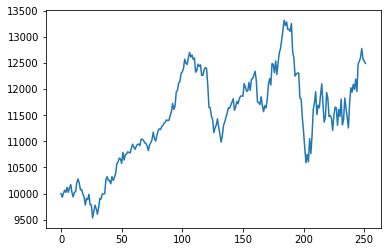

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [27]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.249467
Cumulative returns     0.249467
Annual volatility      0.238682
Sharpe ratio           1.056162
Calmar ratio           1.216109
Stability              0.499041
Max drawdown          -0.205136
Omega ratio            1.194526
Sortino ratio          1.530006
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.911589
Daily value at risk   -0.029071
dtype: float64


In [28]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^GSPC", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.112517
Cumulative returns     0.112046
Annual volatility      0.149492
Sharpe ratio           0.790765
Calmar ratio           0.862325
Stability              0.388079
Max drawdown          -0.130481
Omega ratio            1.139645
Sortino ratio          1.131726
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.856084
Daily value at risk   -0.018365
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.51,2021-12-27,2022-01-21,NaT,NaN
1,13.53,2021-09-03,2021-10-12,2021-12-21,78
2,7.27,2021-04-26,2021-05-12,2021-05-28,25
3,2.32,2021-04-16,2021-04-20,2021-04-23,6
4,1.98,2021-07-12,2021-07-19,2021-07-23,10


Stress Events,mean,min,max
New Normal,0.10%,-4.18%,4.50%


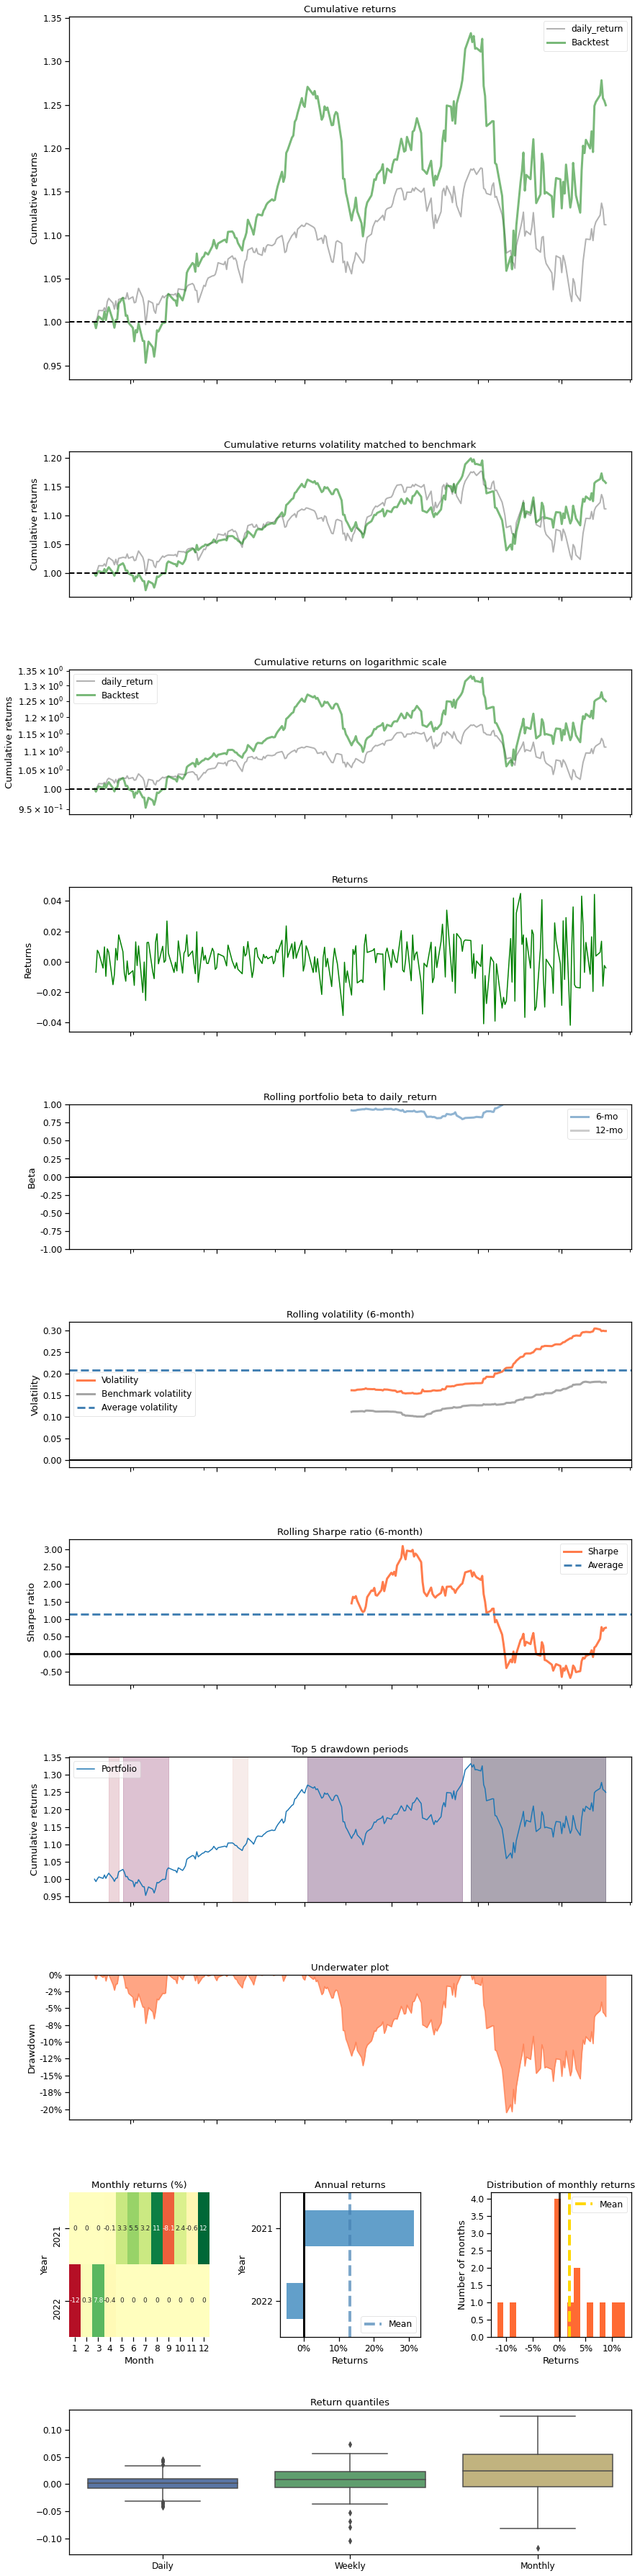

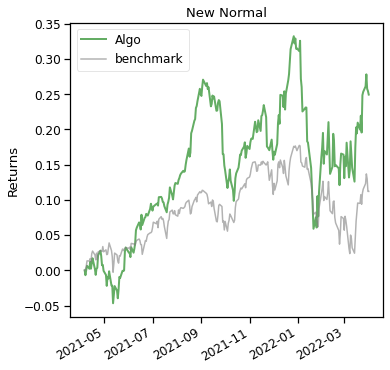

In [29]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^GSPC', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])